### **Dataset:** Medical Appointment No-Shows

### **Pipeline:**

*   Utils
*   Project Definition and Scope
*   Data Collection
*   EDA (Exploratory Data Analysis) - Before Feature Engineering
*   Feature Engineering
*   EDA - After Feature Engineering
*   Data Preprocessing
*   Model Selection, Training and Evaluation
  *   Multi-Layer Perceptron (MLP)
  *   XGBoost
  *   Hybrid Model
*   Conclusion



# Utils
The Utils section contains reusable helper functions that simplify model building, training, evaluation, and logging. It keeps the notebook clean, avoids code repetition, and allows consistent experimentation across different configurations. This structure also makes it easier to test, compare, and document results efficiently.

## MLP - Utils Functions

In [1]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam, SGD, AdamW


def build_mlp_model(input_shape, config):
    """
    Builds a customizable MLP model based on the given configuration.

    Parameters:
        input_shape (tuple): Shape of input features, e.g., (n_features,)
        config (dict): Model hyperparameters including:
            - neurons (list): List of neurons per hidden layer
            - activation (str): 'relu' or 'leakyrelu'
            - optimizer (str): 'adam', 'adamw', or 'sgd'
            - learning_rate (float): Learning rate
            - momentum (float): (for SGD only)
            - dropout (float): Dropout rate between layers

    Returns:
        model (tf.keras.Model): Compiled MLP model
    """

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # Add hidden layers
    for units in config["neurons"]:
        model.add(layers.Dense(units))

        if config["activation"].lower() == "leakyrelu":
            model.add(layers.LeakyReLU(alpha=0.1))
        else:
            model.add(layers.Activation("relu"))

        model.add(layers.Dropout(config["dropout"]))

    # Output layer (binary classification)
    model.add(layers.Dense(1, activation='sigmoid'))

    # Optimizer selection
    lr = config["learning_rate"]
    opt_name = config["optimizer"].lower()

    if opt_name == "adam":
        optimizer = Adam(learning_rate=lr)
    elif opt_name == "adamw":
        optimizer = AdamW(learning_rate=lr)
    elif opt_name == "sgd":
        optimizer = optimizers.SGD(learning_rate=lr, momentum=config.get("momentum", 0.9))
    else:
        raise ValueError(f"Unsupported optimizer: {opt_name}")

    # Compile model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [2]:
# This is built in such a way that it is optional to train with CV
def evaluate_model(X_train, y_train, config, cv=True, n_splits=5, verbose=0):
    """
    Evaluates an MLP model on already split/resampled training data.

    Parameters:
        X_train (array): Feature matrix (resampled if SMOTE used)
        y_train (array): Labels
        config (dict): Model configuration
        cv (bool): Whether to use Stratified K-Fold CV (default: True)
        n_splits (int): Number of folds (if cv=True)
        verbose (int): Training verbosity

    Returns:
        Dict with average F1, Accuracy, Precision, Recall scores
    """
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
    from tensorflow.keras.callbacks import EarlyStopping
    import numpy as np

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    if not cv:
        # Use 20% of training set as validation
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
        )

        model = build_mlp_model(input_shape=(X_train.shape[1],), config=config)

        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=300,
            batch_size=config["batch_size"],
            callbacks=[early_stop],
            verbose=verbose
        )

        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        return {
            "f1": f1_score(y_test, y_pred),
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred)
        }

    else:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        metrics = {
            "f1": [],
            "accuracy": [],
            "precision": [],
            "recall": []
        }

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model = build_mlp_model(input_shape=(X_train.shape[1],), config=config)

            early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

            model.fit(
                X_tr, y_tr,
                validation_data=(X_val, y_val),
                epochs=300,
                batch_size=config["batch_size"],
                callbacks=[early_stop],
                verbose=verbose
            )

            y_pred_prob = model.predict(X_test)
            y_pred = (y_pred_prob > 0.5).astype(int)

            metrics["f1"].append(f1_score(y_test, y_pred))
            metrics["accuracy"].append(accuracy_score(y_test, y_pred))
            metrics["precision"].append(precision_score(y_test, y_pred))
            metrics["recall"].append(recall_score(y_test, y_pred))

            print(f"[Fold {fold}] F1: {metrics['f1'][-1]:.4f}, Acc: {metrics['accuracy'][-1]:.4f}, "
                  f"Prec: {metrics['precision'][-1]:.4f}, Rec: {metrics['recall'][-1]:.4f}")

        return {
            "f1": np.mean(metrics["f1"]),
            "accuracy": np.mean(metrics["accuracy"]),
            "precision": np.mean(metrics["precision"]),
            "recall": np.mean(metrics["recall"])
        }


In [3]:
import pandas as pd

# Global containers
results_log = []
results_df = pd.DataFrame()

def log_results(config, metrics, model_name="Unnamed"):
    """
    Logs the model configuration and performance metrics.
    Supports phase and optional fold tracking for cross-validation.

    Parameters:
        config (dict): Model configuration used
        metrics (dict): Dict with keys ['f1', 'accuracy', 'precision', 'recall']
        model_name (str): Identifier for the model (e.g., "Base", "Best-MLP-128-64")
    """
    global results_log, results_df

    entry = {
        "model_name": model_name,
        "neurons": config["neurons"],
        "activation": config["activation"],
        "optimizer": config["optimizer"],
        "learning_rate": config["learning_rate"],
        "momentum": config.get("momentum", None),
        "dropout": config["dropout"],
        "batch_size": config["batch_size"],
        "f1": round(metrics.get("f1", 0), 4),
        "accuracy": round(metrics.get("accuracy", 0), 4),
        "precision": round(metrics.get("precision", 0), 4),
        "recall": round(metrics.get("recall", 0), 4)
    }

    results_log.append(entry)
    results_df = pd.DataFrame(results_log)

def view_results(sort_by="accuracy", ascending=False):
    """
    Returns a sorted view of the logged results DataFrame.

    Parameters:
        sort_by (str): Metric or column to sort by (default: 'Accuracy')
        ascending (bool): Sort direction (default: False for descending)

    Returns:
        pd.DataFrame: Filtered and sorted results
    """
    if results_df.empty:
        print("No results logged yet.")
        return pd.DataFrame()

    df = results_df.copy()

    return df.sort_values(by=sort_by, ascending=ascending).reset_index(drop=True)


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

def evaluate_and_plot_single_split(X_train, y_train, X_test, y_test, config):
    """
    Trains a model on a single split and plots:
    - Training/validation curves
    - Confusion matrix on the test set
    """
    model = build_mlp_model(input_shape=(X_train.shape[1],), config=config)
    early_stop = EarlyStopping(patience=15, restore_best_weights=True)

    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=config["batch_size"],
        callbacks=[early_stop],
        verbose=1
    )

    # --- Plot training curves ---
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Confusion Matrix ---
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

    return model


In [5]:
import pandas as pd
from google.colab import files

def save_results_csv(filename="mlp_results.csv"):
    """
    Saves the global results DataFrame to a CSV file and downloads it in Colab.
    """
    if results_df.empty:
        print("No results to save.")
        return

    results_df.to_csv(filename, index=False)
    print(f"Results saved to '{filename}'")

    # Download the file in Colab
    files.download(filename)

In [6]:
import pandas as pd

def load_results_csv(filepath):
    """
    Loads results from a CSV file into the global results_df and results_log.
    Allows resuming from saved results after Colab session ends.

    Parameters:
        filepath (str): Path to the CSV file
    """
    global results_df, results_log

    try:
        results_df = pd.read_csv(filepath)
        results_log = results_df.to_dict(orient="records")
        print(f"Results loaded from '{filepath}' — {len(results_df)} entries.")
    except Exception as e:
        print(f"Error loading results from '{filepath}': {e}")


## XGBoost - Utils Functions

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_evaluate_xgboost(X_train_full, y_train_full, X_test, y_test, config, early_stopping_rounds=30):
    """
    Trains and evaluates an XGBoost model using a 20% validation split from the training data.

    Parameters:
        X_train_full: Full training features
        y_train_full: Full training labels
        X_test: Test features
        y_test: Test labels
        config: Dictionary of model hyperparameters
        early_stopping_rounds: Early stopping patience

    Returns:
        Tuple:
            - Dictionary with accuracy, precision, recall, f1-score
            - Trained XGBoost model
    """

    # Stratified 80/20 split of training set for internal validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
    )

    # Convert to DMatrix (optimized internal data structure for XGBoost)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    # XGBoost training parameters
    params = {
      "objective": "binary:logistic",
      "eval_metric": "logloss",
      "learning_rate": config.get("learning_rate", 0.1),
      "max_depth": config.get("max_depth", 5),
      "subsample": config.get("subsample", 1.0),
      "colsample_bytree": config.get("colsample_bytree", 1.0),
      "gamma": config.get("gamma", 0),
      "reg_alpha": config.get("reg_alpha", 0),
      "reg_lambda": config.get("reg_lambda", 1),
      "scale_pos_weight": config.get("scale_pos_weight", 1),
      "verbosity": 0
      }


    evals = [(dtrain, "train"), (dval, "eval")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=config.get("n_estimators", 300),
        evals=evals,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )

    # Predict on test set
    y_pred_probs = model.predict(dtest)
    y_pred = (y_pred_probs > 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }

    return metrics, model


In [8]:
import pandas as pd

# Global storage for XGBoost results
xgb_results_log = []
xgb_results_df = pd.DataFrame()

def log_xgb_results(config, metrics, model_name="XGB_Model"):
    """
    Logs the XGBoost model configuration and performance metrics.

    Parameters:
        config (dict): XGBoost hyperparameters used
        metrics (dict): Evaluation metrics including accuracy, precision, recall, f1_score
        model_name (str): Custom name/identifier for the model configuration
    """
    global xgb_results_log, xgb_results_df

    entry = {
        "model_name": model_name,
        "n_estimators": config.get("n_estimators", None),
        "max_depth": config.get("max_depth", None),
        "learning_rate": config.get("learning_rate", None),
        "subsample": config.get("subsample", None),
        "colsample_bytree": config.get("colsample_bytree", None),
        "gamma": config.get("gamma", None),
        "reg_alpha": config.get("reg_alpha", None),
        "reg_lambda": config.get("reg_lambda", None),
        "accuracy": round(metrics.get("accuracy", 0), 4),
        "precision": round(metrics.get("precision", 0), 4),
        "recall": round(metrics.get("recall", 0), 4),
        "f1_score": round(metrics.get("f1_score", 0), 4)
    }

    xgb_results_log.append(entry)
    xgb_results_df = pd.DataFrame(xgb_results_log)

def view_xgb_results(sort_by="accuracy", ascending=False):
    """
    Returns a sorted view of the logged XGBoost results.

    Parameters:
        sort_by (str): Metric or column to sort by
        ascending (bool): Sort order

    Returns:
        pd.DataFrame: Sorted results
    """
    if xgb_results_df.empty:
        print("No XGBoost results logged yet.")
        return pd.DataFrame()

    return xgb_results_df.sort_values(by=sort_by, ascending=ascending).reset_index(drop=True)

In [9]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import pandas as pd

def visualize_best_xgb_config(best_config, X_train, y_train, X_test, y_test, top_n=10, using_smote=False):
    """
    Re-trains an XGBoost model using the best config, then visualizes feature importance and confusion matrix.

    Parameters:
        best_config (dict): Dictionary of the best XGBoost hyperparameters
        X_train, y_train: Full training data (can be SMOTE-balanced or original)
        X_test, y_test: Test data
        top_n (int): Number of top features to show in importance plot
        using_smote (bool): If True, scale_pos_weight will be ignored
    """

    # Create a safe copy of the config
    model_params = best_config.copy()

    # Remove scale_pos_weight if using SMOTE
    if using_smote:
        model_params.pop("scale_pos_weight", None)

    # Extract scale_pos_weight if it's still present (non-SMOTE case)
    scale_pos_weight = model_params.pop("scale_pos_weight", 1)

    # Initialize and train the model
    model = xgb.XGBClassifier(
        **model_params,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Handle feature names
    if isinstance(X_test, pd.DataFrame):
        feature_names = X_test.columns
    else:
        feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]
        X_test = pd.DataFrame(X_test, columns=feature_names)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(model, importance_type='gain', max_num_features=top_n, height=0.6)
    plt.title(f"Top {top_n} Feature Importances (Gain)")
    plt.grid(False)
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Showed Up", "No-Show"])
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


In [10]:
from google.colab import files

def save_xgb_results_csv(filename="xgb_results.csv"):
    """
    Saves the XGBoost results DataFrame to a CSV file and downloads it in Colab.
    """
    if xgb_results_df.empty:
        print("No XGBoost results to save.")
        return

    xgb_results_df.to_csv(filename, index=False)
    print(f"XGBoost results saved to '{filename}'")
    files.download(filename)

def load_xgb_results_csv(filepath):
    """
    Loads XGBoost results from a CSV file into the global log and dataframe.

    Parameters:
        filepath (str): Path to the CSV file
    """
    global xgb_results_df, xgb_results_log

    try:
        xgb_results_df = pd.read_csv(filepath)
        xgb_results_log = xgb_results_df.to_dict(orient="records")
        print(f"XGBoost results loaded from '{filepath}' — {len(xgb_results_df)} entries.")
    except Exception as e:
        print(f"Error loading XGBoost results: {e}")


# Project Definition and Scope

The goal of this project is to build a machine learning model to predict whether a patient will show up for their scheduled medical appointment. The dataset used comes from a Brazilian public health system and contains over 110,527 medical appointments, each with various demographic, medical, and scheduling-related features.

Missed medical appointments — known as *no-shows* — are a significant issue for healthcare providers. They result in lost time, wasted resources, and delayed treatment. Accurately predicting no-shows allows clinics to proactively intervene, such as by sending reminders, rescheduling, or double-booking slots.

###  Objective
- Analyze and preprocess the Medical Appointment No-Shows dataset.
- Perform feature engineering to create meaningful predictors.
- Train and evaluate multiple machine learning models.
- Identify the best-performing model for predicting appointment no-shows.

###  Target Definition
The original `No-show` column contains:
- `"No"` → Patient **showed up**
- `"Yes"` → Patient **did not show up**

To reduce confusion, we rename this column to `NoShow` and convert it to binary:
- `0` → Patient showed up
- `1` → Patient missed the appointment (positive class)

This binary label will serve as the target variable for the classification models.


# Data Collection

- The dataset can be downloaded online or imported in code from Kaggle.

In [12]:
import pandas as pd

# Set the path of the file
data_path = "/content/KaggleV2-May-2016.csv"

# Load the data into a pandas DataFrame
data = pd.read_csv(data_path)

# Display the shape of the DataFrame
print(f"Data loaded successfully with shape: {data.shape}")

# Print a view of the dataset
data

Data loaded successfully with shape: (110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


# EDA - Before Feature Engineering

## Basic Overview of the Dataset

- Determine the number of instances (rows) and columns (features)




In [20]:
# 1. Determine the number of instances (rows) and columns (features)
num_rows, num_cols = data.shape
print(f"Number of instances (rows): {num_rows}")
print(f"Number of features (columns): {num_cols}")

Number of instances (rows): 110527
Number of features (columns): 14


- Display the first 5 rows

In [21]:
# 2. Display the first 5 rows of the dataset
print("\nFirst 5 rows of the dataset:")
data.head()


First 5 rows of the dataset:


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


- Duisplay the last 5 rows

In [22]:
# 3. Display the last 5 rows of the dataset
print("\nLast 5 rows of the dataset:")
data.tail()


Last 5 rows of the dataset:


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


## General Dataset Information

In [23]:
# General information about the dataset
data.info()

print("\n\n")

# Summary statistics for numerical columns
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB





,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


###  Dataset Overview and Summary Statistics

The dataset contains **110,527 records** and **14 columns**, with **no missing values** across any of the features.

#### Data Types
- **Float64**: 1 column (`PatientId`)
- **Int64**: 8 columns (`AppointmentID`, `Age`, `Scholarship`, `Hipertension`, `Diabetes`, `Alcoholism`, `Handcap`, `SMS_received`)
- **Object (string)**: 5 columns (`Gender`, `ScheduledDay`, `AppointmentDay`, `Neighbourhood`, `No-show`)

####  Summary Statistics Highlights (`.describe()`):
- **Age** ranges from **-1 to 115**. A minimum age of `-1` is invalid and will require cleaning.
- **Binary columns** (0 or 1): `Scholarship`, `Hipertension`, `Diabetes`, `Alcoholism`, `SMS_received`  
  These can be treated as categorical indicators.
- **Handcap** ranges from 0 to 4, but most values are 0 — treatable as ordinal or binary after inspection.
- **High cardinality column**:  
  `PatientId` has many unique values, likely acting as an identifier and not useful for prediction.  
  `AppointmentID` also shows wide numeric spread and can be excluded from modeling.

####  Notes
- The `ScheduledDay` and `AppointmentDay` columns are currently stored as text and will need to be converted to datetime for further analysis.
- The `No-show` column contains `"Yes"`/`"No"` and will be converted to a binary `NoShow` column (1 = missed, 0 = showed up).

Overall, the dataset is clean in terms of null values but contains some anomalies (like negative age) and high-cardinality identifiers that must be addressed before modeling.


## Data quality checks

In [24]:
# Check for missing/null values
missing_values = data.isnull().sum()
print("Missing values per column:\n")
print(missing_values)

# Check for negative age values
negative_ages = data[data['Age'] < 0]
print(f"\nNumber of rows with negative age: {len(negative_ages)}")

# Check unique values in 'Handcap'
print("\nUnique values in 'Handcap':", data['Handcap'].unique())

# Check for values greater than expected (e.g., > 4)
out_of_range_handcap = data[data['Handcap'] > 4]
print(f"Rows with out-of-range 'Handcap' values (>4): {len(out_of_range_handcap)}")
out_of_range_handcap.head()

# Check for exact duplicate rows
duplicate_count = data.duplicated().sum()
print(f"\nNumber of exact duplicate rows: {duplicate_count}")


Missing values per column:

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

Number of rows with negative age: 1

Unique values in 'Handcap': [0 1 2 3 4]
Rows with out-of-range 'Handcap' values (>4): 0

Number of exact duplicate rows: 0


### Data Quality Checks Summary

As observed in the earlier `.info()` step, there are no missing values in any of the 14 columns — confirmed again using `.isnull().sum()`.

- Age: One row contains an invalid value of `-1`, confirming the previously noted anomaly.
- Handcap: Values range from 0 to 4. No out-of-range values (>4) are present.
- Duplicate Rows: There are no exact duplicate rows in the dataset.

These checks confirm the dataset is structurally clean, with only one clear anomaly (negative age) that should be handled during preprocessing.


## Feature Uniqueness Exploration
- Categorical Features

In [25]:
# Quick view of unique values per column
data.nunique()

# View unique values for selected categorical features
for col in ['Gender', 'Neighbourhood', 'No-show']:
    print(f"\n{col} - unique values:\n{data[col].value_counts()}")


Gender - unique values:
Gender
F    71840
M    38687
Name: count, dtype: int64

Neighbourhood - unique values:
Neighbourhood
JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: count, Length: 81, dtype: int64

No-show - unique values:
No-show
No     88208
Yes    22319
Name: count, dtype: int64




While previous steps focused primarily on numerical features, this step inspects the unique values of key **categorical variables**.

- **Gender**: Two categories — `F` (female) and `M` (male), with females making up the majority.
- **Neighbourhood**: Contains 81 unique values, indicating high cardinality. This will require encoding (e.g., one-hot or target encoding) during preprocessing.
- **No-show**: Two values — `"No"` (patient showed up) and `"Yes"` (patient missed). These will be converted to binary (`0` and `1`) for modeling.

This step is essential to confirm category distributions, detect imbalances, and inform appropriate encoding strategies for categorical features.


## Target Variable Analysis

Value counts:

No-show
No     88208
Yes    22319
Name: count, dtype: int64





<ipython-input-26-85481e79241b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='No-show', data=data, palette='pastel')


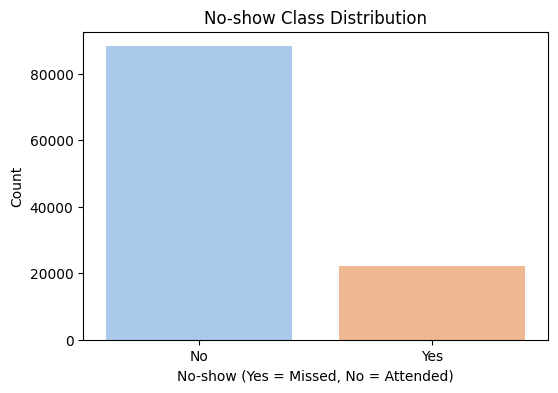

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check value counts for the original 'No-show' column
print("Value counts:\n")
print(data['No-show'].value_counts())

print("\n\n")

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='No-show', data=data, palette='pastel')
plt.title("No-show Class Distribution")
plt.xlabel("No-show (Yes = Missed, No = Attended)")
plt.ylabel("Count")
plt.show()

### Target Variable Analysis – No-show Distribution

The `No-show` column shows a clear class imbalance:

- **"No"** (patient showed up): 88,208 instances (~80%)
- **"Yes"** (patient missed appointment): 22,319 instances (~20%)

This imbalance is also visible in the bar chart.

The imbalance will be considered when selecting evaluation metrics and will be addressed during preprocessing


# Feature Engineering

To enhance the predictive power of the dataset, several new features were engineered based on appointment scheduling dates and time intervals. These features aim to capture behavioral patterns and scheduling dynamics that may influence whether a patient attends their appointment.

### DaysBetween  
**Description**: Number of days between when the appointment was scheduled and when it was held.  
**Purpose**: Captures the waiting time for each patient, which may influence their likelihood of showing up. Longer delays may increase the risk of no-shows.


In [27]:
# Convert to datetime (if not already)
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay']).dt.date
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay']).dt.date

# Convert back to datetime (optional, for subtraction)
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])

# Now calculate DaysBetween
data['DaysBetween'] = (data['AppointmentDay'] - data['ScheduledDay']).dt.days

data['DaysBetween']

,DaysBetween
0,0
1,0
2,0
3,0
4,0
...,...
110522,35
110523,35
110524,41
110525,41


 DaysBetween Calculation – Explanation

1. **Convert to Date Only**:  
   `ScheduledDay` and `AppointmentDay` are first converted to contain only the date (removing the time component) to avoid negative day differences caused by time-of-day differences.

2. **Reconvert to Datetime**:  
   The `.dt.date` format is converted back to full datetime so subtraction can be performed correctly.

3. **Calculate DaysBetween**:  
   The difference in days between the appointment date and the scheduling date is computed using `.dt.days`.

This ensures that appointments scheduled and held on the same calendar day have `DaysBetween = 0`, avoiding rounding errors like `-1`.


### ScheduledWeekday  
**Description**: Indicates the day of the week (0 = Monday, ..., 6 = Sunday) on which the appointment was scheduled.  
**Purpose**: Helps capture booking behavior patterns. Patients scheduling appointments earlier in the week may be more intentional or organized, which could influence attendance rates.


In [28]:
# ScheduledWeekday: weekday when the appointment was scheduled
data['ScheduledWeekday'] = data['ScheduledDay'].dt.dayofweek

data['ScheduledWeekday']

,ScheduledWeekday
0,4
1,4
2,4
3,4
4,4
...,...
110522,1
110523,1
110524,2
110525,2


### AppointmentWeekday  
**Description**: Indicates the day of the week on which the appointment is scheduled to occur (0 = Monday, ..., 6 = Sunday).  
**Purpose**: No-show behavior may vary by day. For instance, patients may be more likely to skip appointments on Mondays or Fridays due to routine disruptions or long weekends.


In [29]:
# AppointmentWeekday: weekday when the appointment takes place
data['AppointmentWeekday'] = data['AppointmentDay'].dt.dayofweek

data['AppointmentWeekday']

,AppointmentWeekday
0,4
1,4
2,4
3,4
4,4
...,...
110522,1
110523,1
110524,1
110525,1


### IsWeekendAppointment  
**Description**: A boolean feature indicating whether the appointment is scheduled on a weekend (Saturday = 5, Sunday = 6).  
**Purpose**: Weekend appointments may affect attendance patterns due to differences in availability, responsibilities, or access to transportation compared to weekdays.


In [30]:
# IsWeekendAppointment: True if appointment is on Saturday or Sunday
data['IsWeekendAppointment'] = data['AppointmentWeekday'].isin([5, 6])

data['IsWeekendAppointment']

,IsWeekendAppointment
0,False
1,False
2,False
3,False
4,False
...,...
110522,False
110523,False
110524,False
110525,False


### Feature Engineering – Pros and Cons

**Pros:**
- **Domain-driven**: Features like `DaysBetween` and `AppointmentWeekday` are based on real-world patient scheduling behavior, making them meaningful and interpretable.
- **Temporal and behavioral context**: The features capture both how far in advance appointments are booked and patterns across different days of the week.
- **Model compatibility**: A mix of continuous and categorical features allows flexibility across various machine learning models.

**Cons:**
- **Redundancy risk**: Some features (e.g., `AppointmentWeekday` and `IsWeekendAppointment`) may convey overlapping information and require correlation checks.
- **Encoding overhead**: Categorical features such as weekdays must be encoded before modeling, adding extra preprocessing steps.
- **No historical behavior**: The features do not include patient history (e.g., past no-shows), which could be a strong predictor but is not available in this dataset.


# EDA - After Feature Engineering

## Dataset Overview After Feature Engineering  
Briefly review the dataset after adding new features to confirm structure and integrity.

In [31]:

# Check updated dataset structure, data types, and non-null counts
data.info()

print("\n\n")

# Preview the first few rows to verify new features
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   PatientId             110527 non-null  float64       
 1   AppointmentID         110527 non-null  int64         
 2   Gender                110527 non-null  object        
 3   ScheduledDay          110527 non-null  datetime64[ns]
 4   AppointmentDay        110527 non-null  datetime64[ns]
 5   Age                   110527 non-null  int64         
 6   Neighbourhood         110527 non-null  object        
 7   Scholarship           110527 non-null  int64         
 8   Hipertension          110527 non-null  int64         
 9   Diabetes              110527 non-null  int64         
 10  Alcoholism            110527 non-null  int64         
 11  Handcap               110527 non-null  int64         
 12  SMS_received          110527 non-null  int64         
 13 

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,DaysBetween,ScheduledWeekday,AppointmentWeekday,IsWeekendAppointment
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,4,4,False
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,4,4,False
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,4,4,False
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,4,4,False
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,4,4,False


### Dataset Overview After Feature Engineering

The dataset now contains 18 columns and 110,527 entries. All newly engineered features (`DaysBetween`, `ScheduledWeekday`, `AppointmentWeekday`, `IsWeekendAppointment`) were added successfully and have valid non-null values.

- Date columns (`ScheduledDay`, `AppointmentDay`) are correctly parsed as `datetime64[ns]`.
- Engineered columns have appropriate types: `int`, `bool`, and `int32` for weekday features.
- No missing values are present, and overall structure remains consistent and ready for further analysis.
- The order of the features has shifted (the target variable is no longer the last one), but this will be fixed during preprocessing

## Demographic and Behavioral Trends

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### No-show Rate by Age (Binned)

<ipython-input-33-72e5df43cf5a>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('AgeGroup')
<ipython-input-33-72e5df43cf5a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeGroup', y='NoShow', data=age_noshow, palette='pastel')


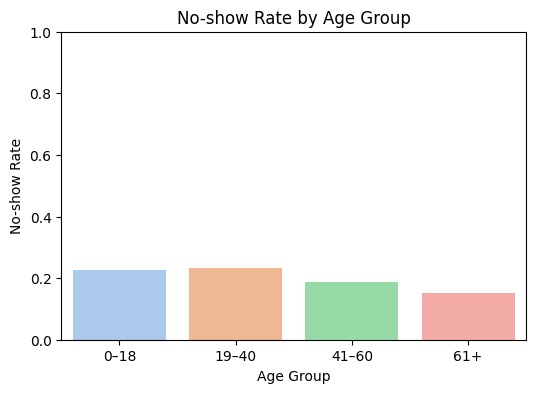

In [33]:
# Create temporary 'NoShow' binary series: 1 = missed appointment, 0 = showed up
no_show_temp = data['No-show'].map({'Yes': 1, 'No': 0})

# Create temporary age bins
age_bins = [0, 18, 40, 60, 100]
age_labels = ['0–18', '19–40', '41–60', '61+']
age_group_temp = pd.cut(data['Age'], bins=age_bins, labels=age_labels)

# Group by temporary AgeGroup and calculate mean no-show rate
age_noshow = (
    pd.DataFrame({'AgeGroup': age_group_temp, 'NoShow': no_show_temp})
    .groupby('AgeGroup')
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='AgeGroup', y='NoShow', data=age_noshow, palette='pastel')
plt.title('No-show Rate by Age Group')
plt.ylabel('No-show Rate')
plt.xlabel('Age Group')
plt.ylim(0, 1)
plt.show()

 No-show Rate by Age Group

The chart displays the average no-show rate across different age groups.  
Younger patients (especially those aged 0–40) tend to miss appointments more frequently, while older patients (particularly 61+) show a lower no-show rate.  
This suggests that age is an informative feature for predicting no-shows.


###  No-show Rate by Gender

<ipython-input-34-ccf7b4b4a420>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='NoShow', data=gender_noshow, palette='pastel')


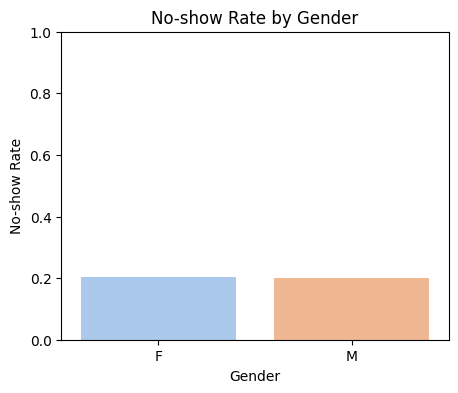

In [34]:
# Temporary binary no-show column
no_show_temp = data['No-show'].map({'Yes': 1, 'No': 0})

# Group by Gender and calculate no-show rate
gender_noshow = (
    pd.DataFrame({'Gender': data['Gender'], 'NoShow': no_show_temp})
    .groupby('Gender')
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(5, 4))
sns.barplot(x='Gender', y='NoShow', data=gender_noshow, palette='pastel')
plt.title('No-show Rate by Gender')
plt.ylabel('No-show Rate')
plt.xlabel('Gender')
plt.ylim(0, 1)
plt.show()

No-show Rate by Gender

This chart shows the average no-show rate for male and female patients.  
The difference between genders is minimal, with both having similar no-show rates.  
This suggests that gender may not be a strong standalone predictor of appointment attendance.


### No-show Rate by Top 10 Neighbourhoods

<ipython-input-35-b98753933627>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Neighbourhood', y='NoShow', data=neigh_noshow, palette='pastel')


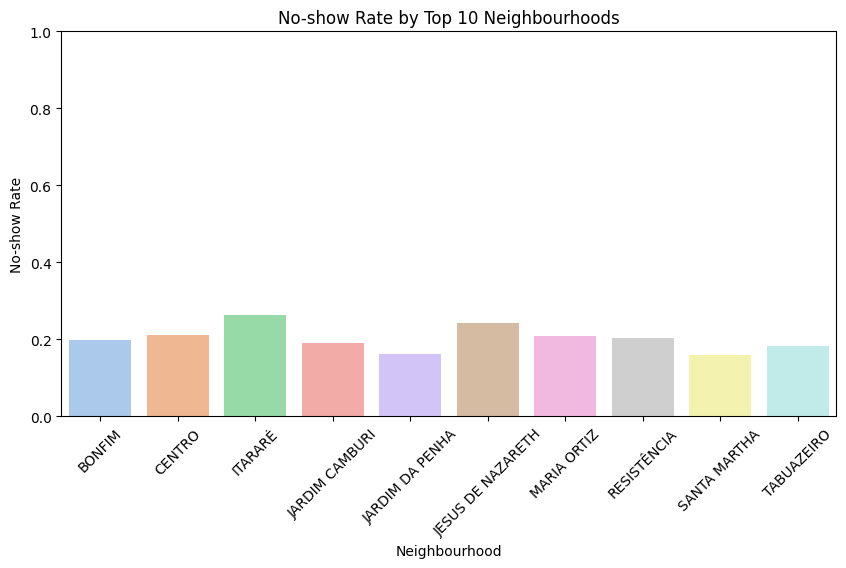

In [35]:
# Get top 10 neighbourhoods by appointment count
top_neighs = data['Neighbourhood'].value_counts().nlargest(10).index
subset_mask = data['Neighbourhood'].isin(top_neighs)

# Build temporary DataFrame with filtered values
neigh_temp_df = pd.DataFrame({
    'Neighbourhood': data['Neighbourhood'][subset_mask],
    'NoShow': no_show_temp[subset_mask]
})

# Group and calculate no-show rate
neigh_noshow = (
    neigh_temp_df.groupby('Neighbourhood')
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Neighbourhood', y='NoShow', data=neigh_noshow, palette='pastel')
plt.title('No-show Rate by Top 10 Neighbourhoods')
plt.ylabel('No-show Rate')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


No-show Rate by Top 10 Neighbourhoods

This chart displays the no-show rates for the ten most represented neighbourhoods in the dataset.  
Noticeable variation exists across areas, with neighbourhoods like ITARARÉ and JESUS DE NAZARETH having higher no-show rates compared to others like JARDIM DA PENHA or SANTA MARTHA.  
These patterns suggest that geographic or socioeconomic factors may influence appointment attendance.


## Correlation Analysis

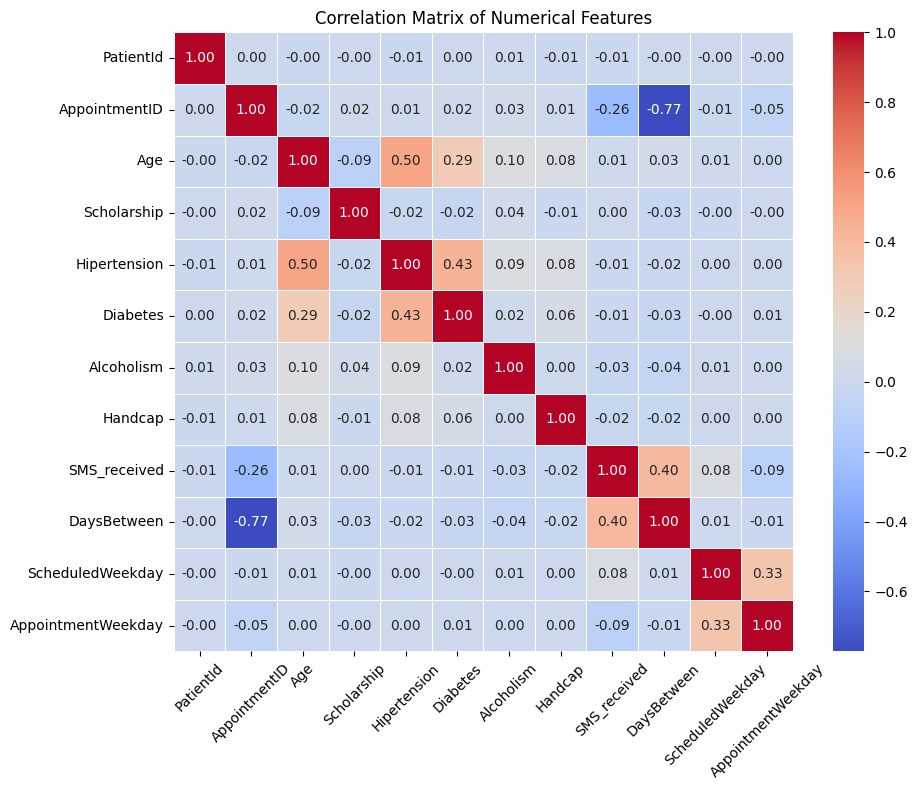

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical features for correlation
numerical_features = data.select_dtypes(include=['int64', 'int32', 'float64'])

# Compute the correlation matrix
corr_matrix = numerical_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

***Correlation Matrix of Numerical Features***

This heatmap visualizes pairwise Pearson correlation coefficients between all numerical features.  
Most features show weak or no linear correlation with one another. A few noteworthy points:
- `Age` has moderate positive correlation with `Hipertension` and `Diabetes`, as expected.
- `ScheduledWeekday` and `AppointmentWeekday` are moderately correlated.
- `DaysBetween` and `AppointmentID` show a strong negative correlation due to sequential ID assignment and scheduling order.

Overall, the low correlations suggest minimal multicollinearity, which is beneficial for many machine learning models.


## Feature Contribution to Target (No-show)

This step analyzes how each feature is associated with the likelihood of a patient missing their appointment. For numerical features, we use point-biserial correlation and boxplots to observe distribution differences. For categorical features, we calculate the average no-show rate for each category and visualize it with bar plots. Additionally, we run a Chi-square test to assess statistical dependence. This helps identify which features are most informative for predicting no-shows.

- Numerical Features

Age → Point-Biserial Correlation: r = -0.060, p = 1.32e-89


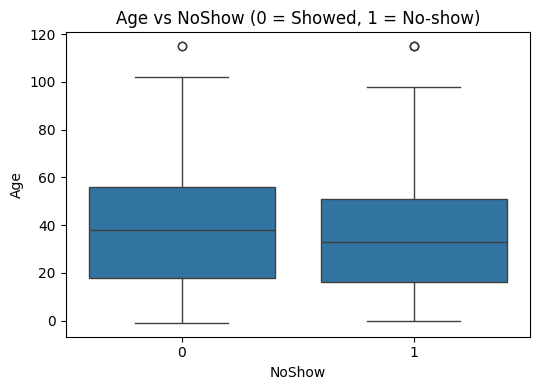

Scholarship → Point-Biserial Correlation: r = 0.029, p = 3.39e-22


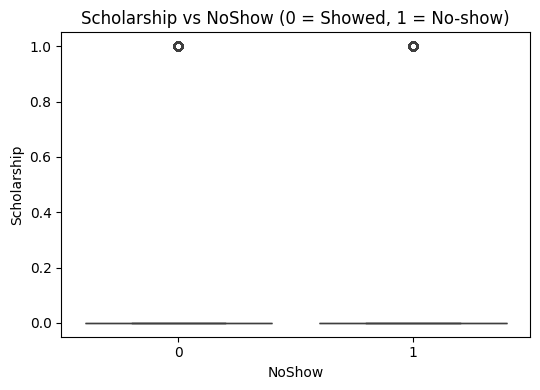

Hipertension → Point-Biserial Correlation: r = -0.036, p = 1.64e-32


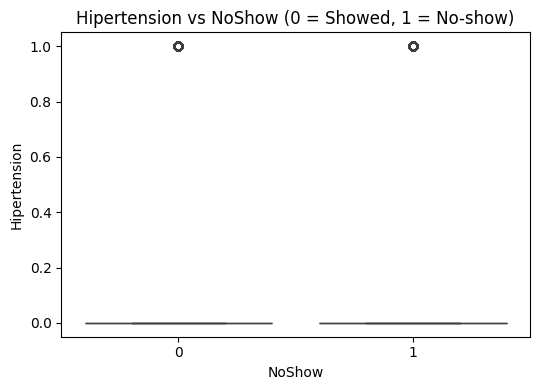

Diabetes → Point-Biserial Correlation: r = -0.015, p = 4.49e-07


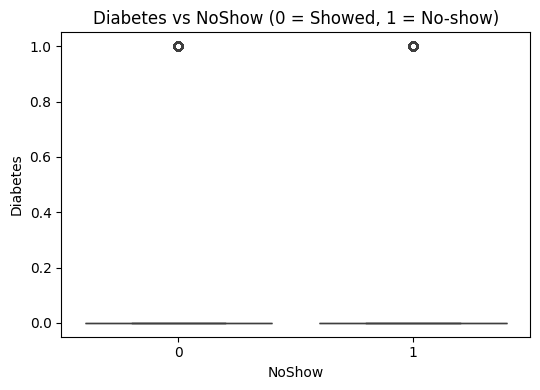

Alcoholism → Point-Biserial Correlation: r = -0.000, p = 9.48e-01


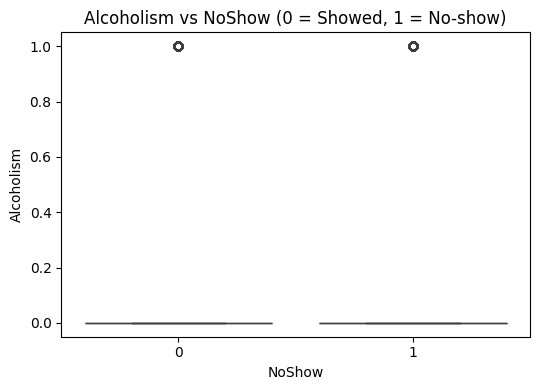

Handcap → Point-Biserial Correlation: r = -0.006, p = 4.34e-02


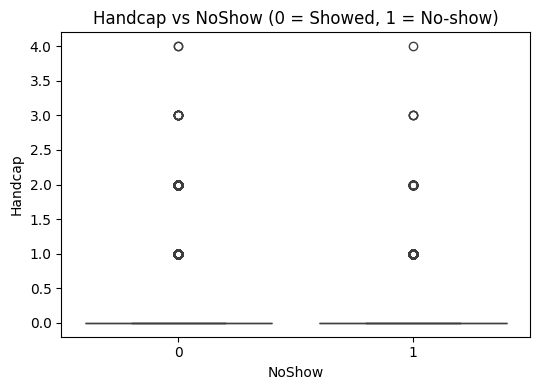

SMS_received → Point-Biserial Correlation: r = 0.126, p = 0.00e+00


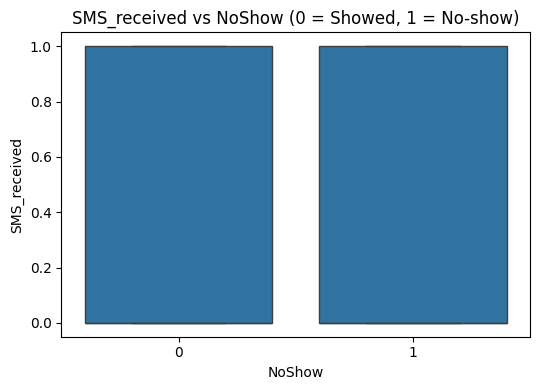

DaysBetween → Point-Biserial Correlation: r = 0.186, p = 0.00e+00


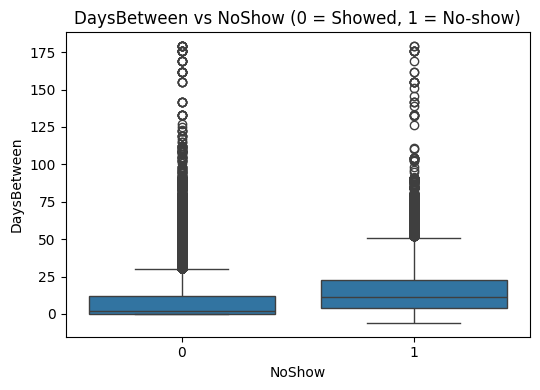

ScheduledWeekday → Point-Biserial Correlation: r = 0.006, p = 4.53e-02


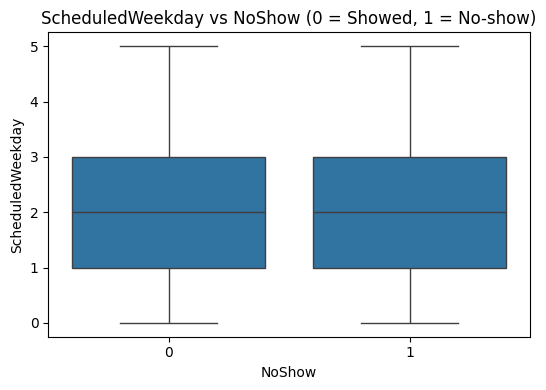

AppointmentWeekday → Point-Biserial Correlation: r = 0.001, p = 6.99e-01


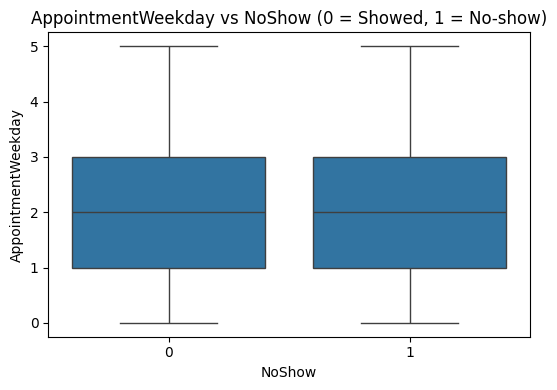

In [37]:
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt

# Temporary binary target
no_show_temp = data['No-show'].map({'Yes': 1, 'No': 0})

# Automatically select numerical features (excluding IDs and target)
exclude_cols = ['PatientId', 'AppointmentID', 'No-show']
num_cols = data.select_dtypes(include=['int64', 'int32', 'float64']).columns
num_cols = [col for col in num_cols if col not in exclude_cols]

# Loop through each numerical feature
for col in num_cols:
    # Skip if constant
    if data[col].nunique() <= 1:
        continue

    # Point-biserial correlation
    corr, pval = pointbiserialr(data[col], no_show_temp)
    print(f"{col} → Point-Biserial Correlation: r = {corr:.3f}, p = {pval:.2e}")

    # Boxplot
    plt.figure(figsize=(5.5, 4))
    sns.boxplot(x=no_show_temp, y=data[col])
    plt.title(f"{col} vs NoShow (0 = Showed, 1 = No-show)")
    plt.xlabel("NoShow")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


- Categorical Features

Gender → Chi-square: χ² = 1.85, p = 1.73e-01


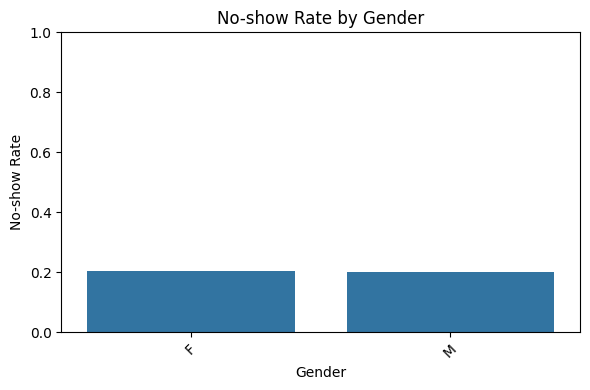

Scholarship → Chi-square: χ² = 93.58, p = 3.91e-22


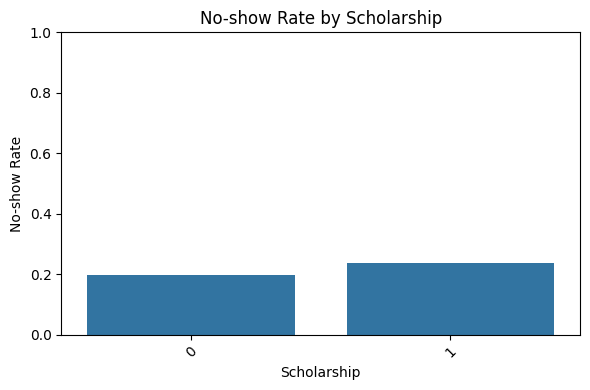

Hipertension → Chi-square: χ² = 140.65, p = 1.92e-32


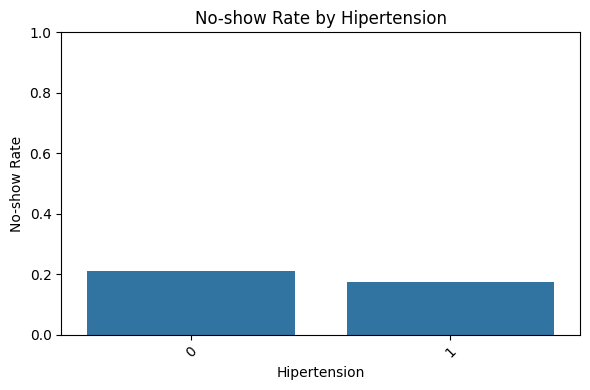

Diabetes → Chi-square: χ² = 25.32, p = 4.85e-07


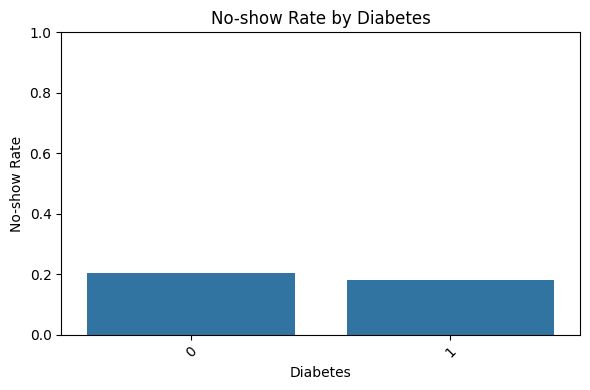

Alcoholism → Chi-square: χ² = 0.00, p = 9.65e-01


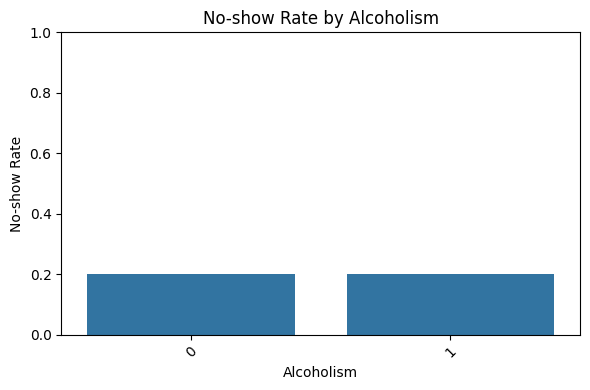

Handcap → Chi-square: χ² = 7.03, p = 1.34e-01


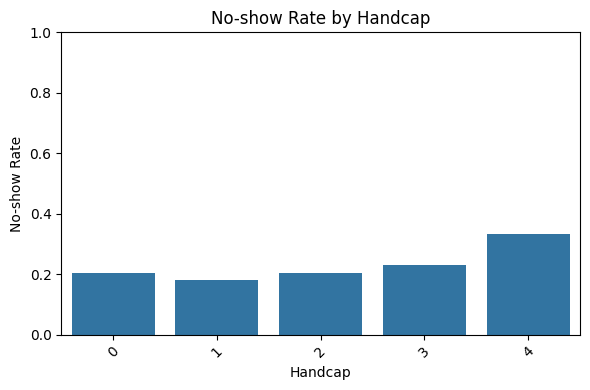

SMS_received → Chi-square: χ² = 1766.07, p = 0.00e+00


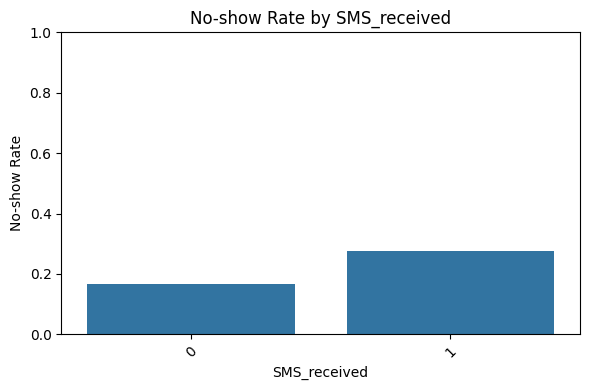

ScheduledWeekday → Chi-square: χ² = 9.03, p = 1.08e-01


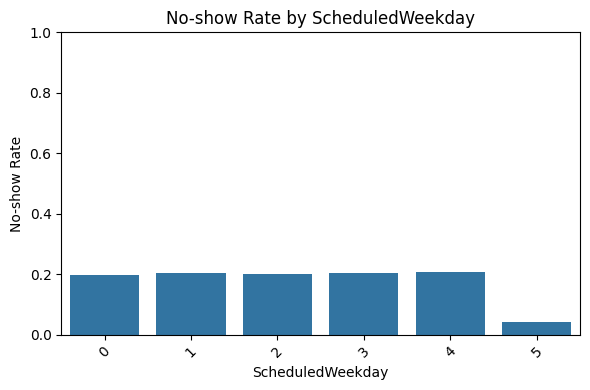

AppointmentWeekday → Chi-square: χ² = 27.47, p = 4.62e-05


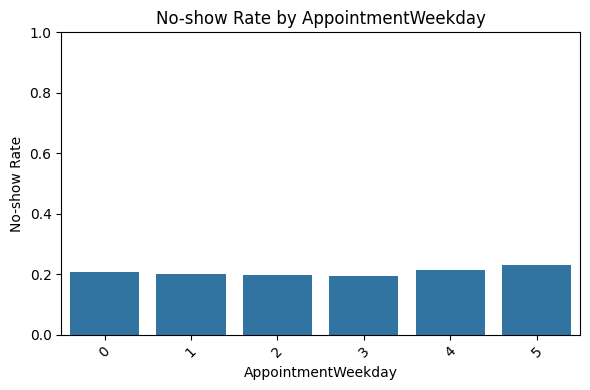

IsWeekendAppointment → Chi-square: χ² = 0.06, p = 8.03e-01


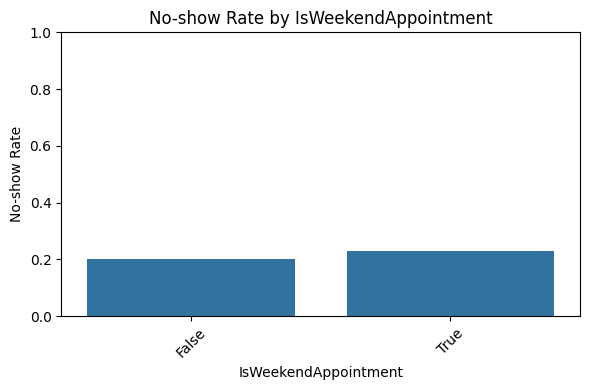

In [38]:
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Temporary binary target
no_show_temp = data['No-show'].map({'Yes': 1, 'No': 0})

# Automatically select categorical features (excluding IDs and high-cardinality columns)
excluded_cols = ['PatientId', 'AppointmentID', 'No-show', 'DaysBetween', 'Age', 'Neighbourhood']
cat_features = [
    col for col in data.columns
    if col not in excluded_cols and data[col].nunique() <= 30 and data[col].dtype in ['object', 'bool', 'int64', 'int32']
]

# Analyze each categorical feature
for col in cat_features:
    # Grouped mean no-show rate
    grouped = data.groupby(col, observed=True)['No-show'].apply(lambda x: (x == 'Yes').mean()).reset_index(name='NoShowRate')

    # Chi-square test
    try:
        contingency = pd.crosstab(data[col], no_show_temp)
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"{col} → Chi-square: χ² = {chi2:.2f}, p = {p:.2e}")
    except:
        print(f"{col} → Chi-square test skipped (invalid input)")

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=col, y='NoShowRate', data=grouped)
    plt.title(f"No-show Rate by {col}")
    plt.ylabel("No-show Rate")
    plt.xlabel(col)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [39]:
# Make a working copy of the data to preserve the original dataset
df = data.copy(deep=True)

- Convert Dates to datetime
- Convert and Rename Target Variable
- Remove Anomalies
- Drop ID Columns and Neighboorhourhood

In [40]:
# Convert ScheduledDay and AppointmentDay to datetime (remove time)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date

# Convert back to full datetime to allow subtraction
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Replace string labels with binary values
df['No-show'] = df['No-show'].replace({'No': 0, 'Yes': 1})

# Remove invalid age values
df = df[df['Age'] >= 0]

# Remove non-predictive identifiers
df.drop(['PatientId', 'AppointmentID',"Neighbourhood"], axis=1, inplace=True)

<ipython-input-40-c1a3312d3a85>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['No-show'] = df['No-show'].replace({'No': 0, 'Yes': 1})
<ipython-input-40-c1a3312d3a85>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['PatientId', 'AppointmentID',"Neighbourhood"], axis=1, inplace=True)


- Normalize Continuous Features
- Encode Binary Categorical Features
- One-Hot Encode Multi-class Categorical Features

In [41]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# -----
# Normalize Continuous Features
scaler = MinMaxScaler()
df[['Age', 'DaysBetween']] = scaler.fit_transform(df[['Age', 'DaysBetween']])

# -----
# Encode Binary Categorical Features

# Properly replace Gender (F=0, M=1)
df['Gender'] = df['Gender'].replace({'F': 0, 'M': 1}).astype(int)

# Other binary columns
binary_cols = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'IsWeekendAppointment']
df[binary_cols] = df[binary_cols].astype(int)

# -----
# One-Hot Encode Multi-class Categorical Features
onehot_cols = ['ScheduledDay', 'AppointmentDay']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df[onehot_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(onehot_cols), index=df.index)

# Drop originals and concatenate encoded columns
df.drop(columns=onehot_cols, inplace=True)
df = pd.concat([df, encoded_df], axis=1)

# -----
# Move target column to the end
target = df.pop('No-show')
df['No-show'] = target

df

<ipython-input-41-908bb1ddfa33>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Age', 'DaysBetween']] = scaler.fit_transform(df[['Age', 'DaysBetween']])
<ipython-input-41-908bb1ddfa33>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'F': 0, 'M': 1}).astype(int)
<ipython-input-41-908bb1ddfa33>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DaysBetween,ScheduledWeekday,...,AppointmentDay_2016-05-25T00:00:00.000000000,AppointmentDay_2016-05-30T00:00:00.000000000,AppointmentDay_2016-05-31T00:00:00.000000000,AppointmentDay_2016-06-01T00:00:00.000000000,AppointmentDay_2016-06-02T00:00:00.000000000,AppointmentDay_2016-06-03T00:00:00.000000000,AppointmentDay_2016-06-06T00:00:00.000000000,AppointmentDay_2016-06-07T00:00:00.000000000,AppointmentDay_2016-06-08T00:00:00.000000000,No-show
0,0,0.539130,0,1,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.486957,0,0,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.539130,0,0,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.069565,0,0,0,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.486957,0,1,1,0,0,0,0.032432,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,0.486957,0,0,0,0,0,1,0.221622,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
110523,0,0.443478,0,0,0,0,0,1,0.221622,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
110524,0,0.182609,0,0,0,0,0,1,0.254054,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
110525,0,0.330435,0,0,0,0,0,1,0.254054,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


### SMOTE Application

In this step, we split the dataset into training and testing sets using an 80/20 ratio with stratification to preserve the original class distribution.

SMOTE (Synthetic Minority Oversampling Technique) is applied **only to the training set** to generate synthetic examples of the minority class (missed appointments). This prevents data leakage and ensures the model does not learn from artificially created patterns that exist in the test set.

By training on a balanced dataset and evaluating on the original, imbalanced test set, we ensure a fair and realistic assessment of model performance.


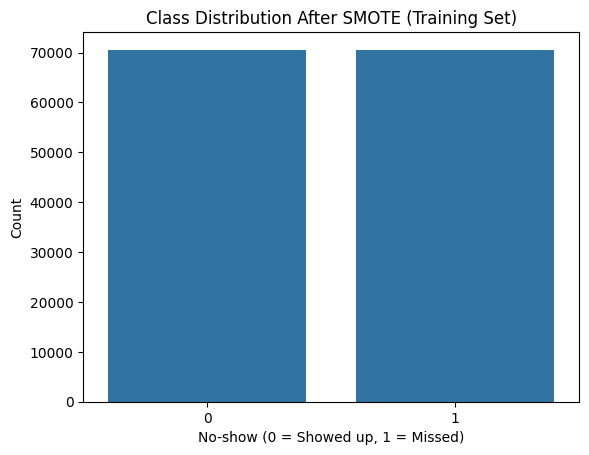





Original training set size: 88420 rows
Original testing set size: 22106 rows
Training set size after SMOTE: 141130 rows


In [42]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Separate features and target
X = df.drop('No-show', axis=1)
y = df['No-show']

# 2. Split into training and testing sets (stratify to maintain imbalance in test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 4. Visualize class balance in the resampled training set
sns.countplot(x=y_train_smote)
plt.title("Class Distribution After SMOTE (Training Set)")
plt.xlabel("No-show (0 = Showed up, 1 = Missed)")
plt.ylabel("Count")
plt.show()

print("\n\n\n")

# Original training and testing set sizes
print(f"Original training set size: {X_train.shape[0]} rows")
print(f"Original testing set size: {X_test.shape[0]} rows")

# After SMOTE
print(f"Training set size after SMOTE: {X_train_smote.shape[0]} rows")


The training set was balanced using SMOTE to address class imbalance. Originally, the training set had 88,420 samples, which increased to 141,130 after synthetic examples were added. The class distribution is now even (0 = showed up, 1 = missed), as shown in the bar plot, helping improve model performance and fairness.

# Multi-Layer Perceptron (MLP) – Model Development Strategy

## Objective

We aim to build a strong Multi-Layer Perceptron (MLP) model to classify whether a patient will miss their medical appointment. The model will be tuned and validated through systematic experimentation to ensure both performance and reliability.

---

## Training & Evaluation Strategy

We adopt a **stepwise experimentation approach** to tune the MLP effectively:

- Each configuration is trained on a fixed train-validation split.
- Metrics tracked include: **accuracy**, **F1-score**, **precision**, **recall**.
- **EarlyStopping** is applied with `patience = 15` and `restore_best_weights = True` to prevent overfitting.
- The **best-performing configuration** is selected based on testing Accuracy and metric stability.

Once the best configuration is identified, it is **retrained on the same split** for **visualization and final metric reporting purposes**.

---

## Base MLP Model Configuration

- **Hidden Layers**: 2  
- **Neurons**: [128, 64]  
- **Activation**: ReLU  
- **Optimizer**: Adam  
- **Learning Rate**: 0.001  
- **Dropout**: 0.3  
- **Batch Size**: 32  
- **Epochs**: 300  
- **EarlyStopping**: `patience = 15`, `restore_best_weights = True`

This model serves as the reference baseline for all experimentation.

---

## Hyperparameters to Experiment With

### Architecture

- Layers: 1, 2, 3  
- Neurons:  
  - 1 layer: [64], [128]  
  - 2 layers: [64, 32], [128, 64], [256, 128]  
  - 3 layers: [128, 64, 32], [256, 128, 64], [512, 256, 128]  

### Activation Functions

- ReLU  
- LeakyReLU  

### Optimizers

- Adam  
- SGD with Momentum  
- AdamW  

### Learning Rates

- *Adam*: 0.001, 0.0005, 0.0003, 0.0001  
- *SGD*: 0.01, 0.005, 0.001  

### Momentum (SGD only)

- 0.90, 0.95, 0.99  

### Dropout

- 0.2, 0.3, 0.5  

### Batch Sizes

- 32, 64, 128  

---

## Experimentation Workflow

- Use a **stepwise tuning** strategy: modify one hyperparameter group at a time while keeping the others fixed.  
- Log each run with performance plots and tracked metrics.  
- Retrain the **final best model** once more to generate interpretable metrics and final visualizations.


In [ ]:
import tensorflow as tf
print("Running on GPU:", tf.config.list_physical_devices('GPU'))

Running on GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Base MLP Model

In [ ]:
base_config = {
    "neurons": [128, 64],
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "momentum": None,             # only needed for SGD
    "dropout": 0.3,
    "batch_size": 32
}

metrics = evaluate_model(X_train_smote, y_train_smote, config=base_config, cv=False, verbose=1)

In [ ]:
log_results(base_config, metrics, model_name="Baseline MLP")

save_results_csv(filename="mlp_results.csv")

view_results()

Results saved to 'mlp_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,phase,model_name,cv_fold,neurons,activation,optimizer,learning_rate,momentum,dropout,batch_size,f1,accuracy,precision,recall
0,2,Baseline MLP,None,"[128, 64]",relu,adam,0.001,None,0.3,32,0.7442,0.7237,0.6928,0.8046


## Other MLP configurations

### Base Configuration Setup

We define a `base_config` dictionary to store the initial MLP model settings. This serves as a reference point for all experiments.  
The configuration is then copied to `best_config`, which will be updated if a better-performing configuration is found during tuning (based on testing accuracy).  
At the end of experimentation, the best configuration is printed and used to retrain the model once more for final metric reporting and visualization.


In [ ]:
# Base configuration
base_config = {
    "neurons": [128, 64],
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "momentum": None,
    "dropout": 0.3,
    "batch_size": 32
}

# For tracking best configuration
best_config = base_config.copy()
best_score = -1

### Layers and Neurons per Layer

We experiment with different MLP depths and layer widths to assess how model complexity affects performance:

- **1 hidden layer**: [64], [128]  
- **2 hidden layers**: [64, 32], [128, 64], [256, 128]  
- **3 hidden layers**: [128, 64, 32], [256, 128, 64], [512, 256, 128]  

This allows us to evaluate both shallow and deep architectures with increasing capacity.

In [ ]:
layer_configs = {
    1: [[64], [128]],
    2: [[64, 32], [128, 64], [256, 128]],
    3: [[128, 64, 32], [256, 128, 64], [512, 256, 128]]
}

print("Experimenting with Layers and Neurons")
for n_layers, neuron_sets in layer_configs.items():
    for neurons in neuron_sets:
        config = best_config.copy()
        config["neurons"] = neurons
        metrics = evaluate_model(X_train_smote, y_train_smote, config=config, cv=False, verbose=1)
        model_label = f"Layers-{n_layers}"
        log_results(config, metrics, model_name=model_label)
        if metrics["accuracy"] > best_score:
            best_score = metrics["accuracy"]
            best_config["neurons"] = neurons

### Activation Function

Activation functions introduce non-linearity into the network, enabling it to learn complex patterns. We compare:

- **ReLU**: Fast convergence, widely used baseline  
- **LeakyReLU**: Addresses ReLU’s “dying neuron” issue by allowing a small gradient when inactive  


In [ ]:
activations = ['relu', 'leakyrelu']

print("Experimenting with Activation Functions")

for act in activations:
    config = best_config.copy()
    config["activation"] = act

    metrics = evaluate_model(X_train_smote, y_train_smote, config=config, cv=False, verbose=1)

    model_label = f"Activation-{act.capitalize()}"
    log_results(config, metrics, model_name=model_label)

    print(model_label, "finished")
    if metrics["accuracy"] > best_score:
        best_score = metrics["accuracy"]
        best_config["activation"] = act

### Optimizers

The choice of optimizer influences training dynamics. We evaluate:

- **Adam**: Adaptive method combining momentum and RMSProp (default baseline)  
- **SGD with Momentum**: Tested with momentum values 0.90, 0.95, and 0.99  
- **AdamW**: Adam variant with decoupled weight decay, better generalization in some cases  

Each optimizer is paired with appropriate learning rate ranges for best tuning.

In [ ]:
print("Experimenting with Adam and AdamW Optimizers")

optimizer_names = ["adam", "adamw"]
lr_list = [0.001, 0.0005, 0.0003, 0.0001]

for opt in optimizer_names:
    for lr in lr_list:
        config = best_config.copy()
        config["optimizer"] = opt
        config["learning_rate"] = lr
        config["momentum"] = None  # Not used for Adam/AdamW

        metrics = evaluate_model(X_train_smote, y_train_smote, config=config, cv=False, verbose=1)
        model_label = f"{opt.upper()}-LR{lr}"
        log_results(config, metrics, model_name=model_label)

        print(model_label, "finished")
        if metrics["accuracy"] > best_score:
            best_score = metrics["accuracy"]
            best_config.update(config)


In [ ]:
print("Experimenting with SGD Optimizer")

lr_list = [0.1, 0.005, 0.001]
momentums = [0.9, 0.95, 0.99]

for lr in lr_list:
    for momentum in momentums:
        config = best_config.copy()
        config["optimizer"] = "sgd"
        config["learning_rate"] = lr
        config["momentum"] = momentum

        metrics = evaluate_model(X_train_smote, y_train_smote, config=config, cv=False, verbose=1)
        model_label = f"SGD-LR{lr}-M{momentum}"
        log_results(config, metrics model_name=model_label)

        print(model_label, "finished")
        if metrics["accuracy"] > best_score:
            best_score = metrics["accuracy"]
            best_config.update(config)


### Dropout

Dropout is used to prevent overfitting by randomly deactivating neurons during training. We experiment with:

- **0.2**: Light regularization  
- **0.3**: Moderate regularization (default)  
- **0.5**: Aggressive regularization  

In [ ]:
print("Experimenting with Dropout")

dropout_list = [0.2, 0.5]

for dr in dropout_list:
        config = best_config.copy()
        config["dropout"] = dr
        metrics = evaluate_model(X_train_smote, y_train_smote, config=config, cv=False, verbose=1)
        model_label = f"Dropout - {dr}"
        log_results(config, metrics, model_name=model_label)

        print(model_label, "finished")
        if metrics["accuracy"] > best_score:
            best_score = metrics["accuracy"]
            best_config.update(config)

### Batch Size

Batch size impacts convergence speed and training stability. We experiment with:

- **32**: Stable baseline, suitable for smaller memory settings  
- **64**: Faster convergence with stable updates  
- **128**: Larger batches for smoother gradients (only if memory allows)

In [ ]:
print("Experimenting with Batch Size")

batch_size_list = [64, 128] # The experiment with batch size 32 is already done in the previous runs

for batch in batch_size_list:
        config = best_config.copy()
        config["batch_size"] = batch
        metrics = evaluate_model(X_train_smote, y_train_smote, config=config, cv=False, verbose=1)
        model_label = f"Batch-Size - {batch}"
        log_results(config, metrics, phase="Phase 1", model_name=model_label)

        print(model_label, "finished \n\n")
        if metrics["accuracy"] > best_score:
            best_score = metrics["accuracy"]
            best_config.update(config)

### Best Configuration: Final Model

The best-performing configuration from the experimentation phase is shown below.  
It is now retrained on the same train-validation split to produce consistent evaluation metrics and enable result visualization (e.g., training curves and confusion matrix).


In [ ]:
# Showing the best performing configuration based on accuracy
print("Best Configuration: \n", best_config)

print()

results_df.tail(1) # The last configuration in this case

Best Configuration: 
 {'neurons': [256, 128, 64], 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'momentum': None, 'dropout': 0.3, 'batch_size': 128}



,model_name,neurons,activation,optimizer,learning_rate,momentum,dropout,batch_size,f1,accuracy,precision,recall
31,Batch-Size - 128,"[256, 128, 64]",relu,adam,0.0001,0.0,0.3,128,0.7591,0.741,0.7096,0.816


In [ ]:
best_model = evaluate_and_plot_single_split(X_train_smote, y_train_smote, X_test, y_test, best_config)

### Conclusion - MLP

The MLP experimentations were concluded with a total of 32 different configurations, with the best performing one shown in the previous steps.

Below the dataframe of logged results will be shown in descending order based on accuracy.

In [ ]:
view_results() # Show configurations in descdending order based on Accuracy

,model_name,neurons,activation,optimizer,learning_rate,momentum,dropout,batch_size,f1,accuracy,precision,recall
0,Batch-Size - 128,"[256, 128, 64]",relu,adam,0.0001,0.00,0.3,128,0.7591,0.7410,0.7096,0.8160
1,ADAM-LR0.0001,"[256, 128, 64]",relu,adam,0.0001,0.00,0.3,32,0.7559,0.7389,0.7095,0.8088
2,Activation-Relu,"[256, 128, 64]",relu,adam,0.0010,0.00,0.3,32,0.7574,0.7383,0.7058,0.8172
3,ADAM-LR0.001,"[256, 128, 64]",relu,adam,0.0010,0.00,0.3,32,0.7578,0.7366,0.7014,0.8240
4,Batch-Size - 64,"[256, 128, 64]",relu,adam,0.0001,0.00,0.3,64,0.7548,0.7359,0.7044,0.8129
5,Dropout - 0.2,"[256, 128, 64]",relu,adam,0.0001,0.00,0.2,32,0.7522,0.7347,0.7058,0.8051
6,Layers-3,"[256, 128, 64]",relu,adam,0.0010,0.00,0.3,32,0.7515,0.7344,0.7061,0.8032
7,ADAM-LR0.0003,"[256, 128, 64]",relu,adam,0.0003,0.00,0.3,32,0.7533,0.7336,0.7015,0.8132
8,Layers-2,"[256, 128]",relu,adam,0.0010,0.00,0.3,32,0.7580,0.7334,0.6941,0.8349
9,Dropout - 0.5,"[256, 128, 64]",relu,adam,0.0001,0.00,0.5,32,0.7469,0.7322,0.7080,0.7903


In [ ]:
# Optionally save the results in a csv file locally
save_results_csv("mlp_results.csv")

# XGBoost – Model Development Strategy

## Objective

We aim to develop a high-performing XGBoost classifier to predict medical appointment no-shows. The model will be fine-tuned through a systematic stepwise approach, focusing on both accuracy and generalization capability.

---

## Training & Evaluation Strategy

We adopt a **stepwise tuning strategy** for hyperparameter optimization:

- A **stratified 20% validation split** is used from the training data to evaluate model performance during training.
- **EarlyStopping** is applied with `early_stopping_rounds = 30`
- The validation set is strictly used for training feedback — no predictions are made on it post-training.
- The **best configuration** is selected based on validation accuracy and metric stability across experiments.

---

## Baseline XGBoost Configuration

- **n_estimators**: 300  
- **max_depth**: 5  
- **learning_rate**: 0.1  
- **subsample**: 1.0  
- **colsample_bytree**: 1.0  
- **gamma**: 0  
- **reg_alpha**: 0  
- **reg_lambda**: 1  

This baseline serves as a starting point for the tuning process.

---

## Hyperparameters to Experiment With

### Learning Rate
- 0.3, 0.1, 0.05, 0.01

### Number of Estimators (Boosting Rounds)
- 100, 200, 300, 500, 800, 1000, 1500

### Max Depth
- 3, 5, 7, 9

### Subsample Ratio (Row Sampling per Tree)
- 0.6, 0.7, 0.8, 0.9, 1.0

### Colsample_bytree (Feature Sampling per Tree)
- 0.5, 0.7, 0.9, 1.0

### Gamma (Minimum Loss Reduction)
- 0, 1, 5, 10

### Regularization - L1 (reg_alpha)
- 0, 0.1, 1, 5, 10

### Regularization - L2 (reg_lambda)
- 0, 1, 5, 10, 20

---

## Experimentation Workflow

- Tune one hyperparameter group at a time while holding others fixed to isolate performance impact.
- Order of experimentation:
  1. `learning_rate`  
  2. `n_estimators`  
  3. `max_depth`  
  4. `subsample`  
  5. `colsample_bytree`  
  6. `gamma`  
  7. `reg_alpha`  
  8. `reg_lambda`  

- The final best model will be retrained once more on the full training split for visualization and final metric reporting.


## Baseline XGBoost Model

In [ ]:
# Baseline configuration for XGBoost
base_config = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "gamma": 0,
    "reg_alpha": 0,
    "reg_lambda": 1
}

# Train and evaluate the base model
metrics, model = train_and_evaluate_xgboost(
    X_train_full=X_train_smote,
    y_train_full=y_train_smote,
    X_test=X_test,
    y_test=y_test,
    config=base_config
)

# Log the result
log_xgb_results(base_config, metrics, model_name="XGB_Base")

# View it
view_xgb_results()


,model_name,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,accuracy,precision,recall,f1_score
0,XGB_Base,300,5,0.1,1.0,1.0,0,0,1,0.67,0.3253,0.5901,0.4194


## Other XGBoost Configurations

 We'll train XGBoost twice to compare how class imbalance is handled:
 - First, using SMOTE to oversample the minority class in the training set.
 - Then, without SMOTE, using XGBoost's built-in scale_pos_weight parameter.

This helps us understand which method gives better performance for this specific dataset.


### XGBoost with SMOTE

We retrain the best XGBoost configuration using SMOTE to oversample the minority class (no-shows) in the training set. This allows us to compare the effect of synthetic class balancing against XGBoost’s built-in imbalance handling via `scale_pos_weight`.

The goal is to evaluate whether SMOTE improves recall and F1-score or if it leads to overfitting and reduced generalization. Results from both versions will be compared side by side.

In [ ]:
import copy

# Define the full hyperparameter grid for tuning (in order)
tuning_grid = {
    "learning_rate": [0.3, 0.1, 0.05, 0.01],
    "n_estimators": [100, 200, 300, 500, 800, 1000, 1500],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.9, 1.0],
    "gamma": [0, 1, 5, 10],
    "reg_alpha": [0, 0.1, 1, 5, 10],
    "reg_lambda": [0, 1, 5, 10, 20]
}

# Start from the baseline config
best_config = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "gamma": 0,
    "reg_alpha": 0,
    "reg_lambda": 1
}

best_accuracy = -1
tuning_log = []

# Perform stepwise tuning
for param_name, values in tuning_grid.items():
    print(f"\nTuning: {param_name}")
    current_best = best_config[param_name]

    for val in values:
        temp_config = best_config.copy()
        temp_config[param_name] = val

        # Train and evaluate
        metrics, _ = train_and_evaluate_xgboost(
            X_train_full=X_train_smote,
            y_train_full=y_train_smote,
            X_test=X_test,
            y_test=y_test,
            config=temp_config
        )

        # Log the result using your utils
        log_xgb_results(temp_config, metrics, model_name=f"Tune-{param_name}={val}")

        # Track the best config
        acc = metrics["accuracy"]
        if acc > best_accuracy:
            best_accuracy = acc
            best_config[param_name] = val
            print(f"New best: {param_name} = {val} | Accuracy = {acc:.4f}")
        else:
            print(f"Tried: {param_name} = {val} | Accuracy = {acc:.4f}")

best_config, best_accuracy


Tuning: learning_rate
New best: learning_rate = 0.3 | Accuracy = 0.7068
Tried: learning_rate = 0.1 | Accuracy = 0.6700
Tried: learning_rate = 0.05 | Accuracy = 0.6315
Tried: learning_rate = 0.01 | Accuracy = 0.6047

Tuning: n_estimators
Tried: n_estimators = 100 | Accuracy = 0.6759
Tried: n_estimators = 200 | Accuracy = 0.7009
Tried: n_estimators = 300 | Accuracy = 0.7068
New best: n_estimators = 500 | Accuracy = 0.7152
New best: n_estimators = 800 | Accuracy = 0.7159
New best: n_estimators = 1000 | Accuracy = 0.7183
Tried: n_estimators = 1500 | Accuracy = 0.7183

Tuning: max_depth
Tried: max_depth = 3 | Accuracy = 0.7145
Tried: max_depth = 5 | Accuracy = 0.7183
Tried: max_depth = 7 | Accuracy = 0.7174
New best: max_depth = 9 | Accuracy = 0.7185

Tuning: subsample
Tried: subsample = 0.6 | Accuracy = 0.7094
Tried: subsample = 0.7 | Accuracy = 0.7137
Tried: subsample = 0.8 | Accuracy = 0.7137
Tried: subsample = 0.9 | Accuracy = 0.7132
Tried: subsample = 1.0 | Accuracy = 0.7185

Tuning: 

({'n_estimators': 1000,
  'max_depth': 9,
  'learning_rate': 0.3,
  'subsample': 1.0,
  'colsample_bytree': 1.0,
  'gamma': 0,
  'reg_alpha': 0,
  'reg_lambda': 1},
 0.7184927169094364)

In [ ]:
# A view of every configuration we have done so far with smote
view_xgb_results() # In descending order so the first row is best_config

,model_name,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,accuracy,precision,recall,f1_score
0,Tune-gamma=0,1000,9,0.30,1.0,1.0,0,0.0,1,0.7185,0.3399,0.4182,0.3750
1,Tune-reg_alpha=0,1000,9,0.30,1.0,1.0,0,0.0,1,0.7185,0.3399,0.4182,0.3750
2,Tune-reg_lambda=1,1000,9,0.30,1.0,1.0,0,0.0,1,0.7185,0.3399,0.4182,0.3750
3,Tune-colsample_bytree=1.0,1000,9,0.30,1.0,1.0,0,0.0,1,0.7185,0.3399,0.4182,0.3750
4,Tune-subsample=1.0,1000,9,0.30,1.0,1.0,0,0.0,1,0.7185,0.3399,0.4182,0.3750
5,Tune-max_depth=9,1000,9,0.30,1.0,1.0,0,0.0,1,0.7185,0.3399,0.4182,0.3750
6,Tune-n_estimators=1000,1000,5,0.30,1.0,1.0,0,0.0,1,0.7183,0.3397,0.4185,0.3750
7,Tune-max_depth=5,1000,5,0.30,1.0,1.0,0,0.0,1,0.7183,0.3397,0.4185,0.3750
8,Tune-n_estimators=1500,1500,5,0.30,1.0,1.0,0,0.0,1,0.7183,0.3397,0.4185,0.3750
9,Tune-reg_alpha=10,1000,9,0.30,1.0,1.0,0,10.0,1,0.7178,0.3404,0.4236,0.3774


<Figure size 1000x600 with 0 Axes>

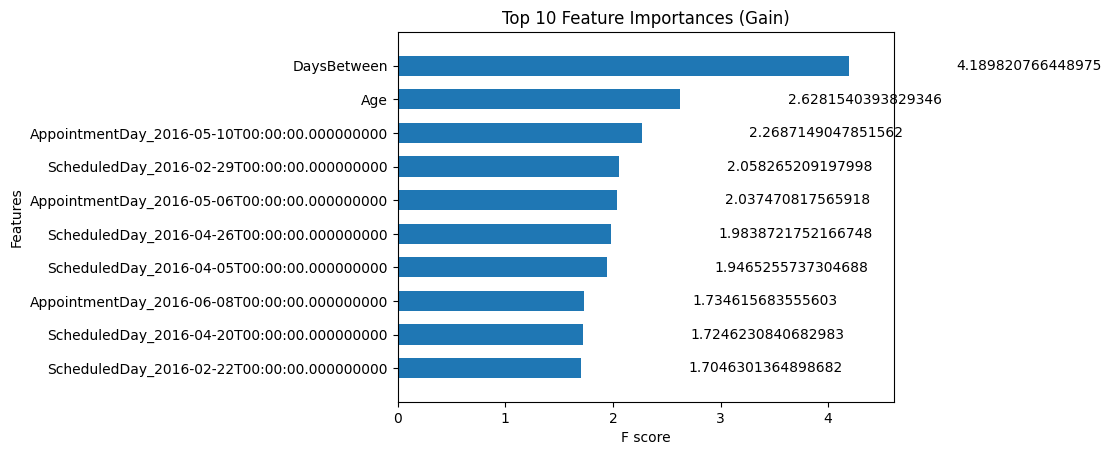

<Figure size 600x600 with 0 Axes>

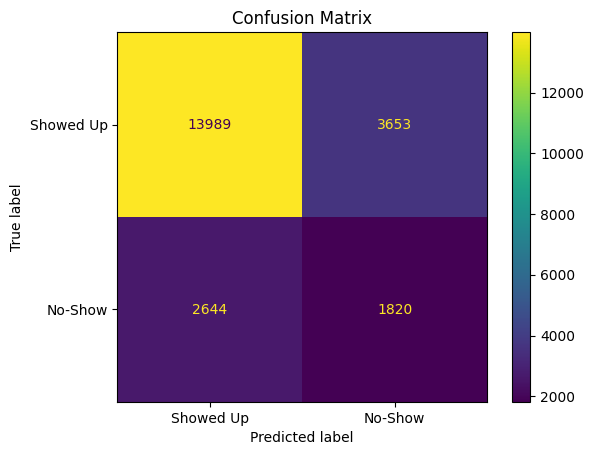

In [ ]:
# Visualization on the best performing configuration
visualize_best_xgb_config(best_config, X_train_smote, y_train_smote, X_test, y_test)

- Evaluation of XGBoost with SMOTE

The confusion matrix shows that the model correctly identifies a portion of no-shows (1,820 out of 4,464) with a recall of approximately 41%. However, precision is relatively low (~33%), as many predicted no-shows were actually show-ups (3,653 false positives). This leads to an overall F1-score of around 0.36–0.37, indicating a modest balance between precision and recall.

The feature importance plot highlights 'DaysBetween' and 'Age' as the most informative features, which aligns with domain expectations. However, several highly ranked features are specific timestamp-based one-hot encodings of appointment or scheduled dates. This suggests potential overfitting to individual days rather than general patterns, reducing the model's ability to generalize.

In summary, the model performs better than random guessing, but shows signs of limited generalization and struggles to achieve high precision or recall on no-show cases.


### XGBoost without SMOTE

We retrain the best XGBoost configuration on the original, imbalanced dataset without applying SMOTE. Instead, we rely on XGBoost’s built-in `scale_pos_weight` parameter to handle class imbalance by increasing the penalty for misclassifying the minority class (no-shows).

This approach avoids introducing synthetic data and preserves the original distribution of the training set. The goal is to evaluate whether native imbalance handling leads to more robust and generalizable performance, particularly in terms of precision, recall, and F1-score.

The results will be compared directly with the SMOTE-based version to assess which method is more effective for this dataset.


In [ ]:
import copy

# Compute class imbalance ratio for scale_pos_weight
neg, pos = np.bincount(y_train)
imbalance_ratio = neg / pos

# Define the full hyperparameter grid (same as before)
tuning_grid = {
    "learning_rate": [0.3, 0.1, 0.05, 0.01],
    "n_estimators": [100, 200, 300, 500, 800, 1000, 1500],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.9, 1.0],
    "gamma": [0, 1, 5, 10],
    "reg_alpha": [0, 0.1, 1, 5, 10],
    "reg_lambda": [0, 1, 5, 10, 20]
}

# Updated baseline config (add scale_pos_weight)
best_config = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "gamma": 0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "scale_pos_weight": imbalance_ratio,
}

best_accuracy = -1
tuning_log = []

# Stepwise tuning (same logic)
for param_name, values in tuning_grid.items():
    print(f"\nTuning: {param_name}")
    current_best = best_config[param_name]

    for val in values:
        temp_config = best_config.copy()
        temp_config[param_name] = val

        # Train and evaluate using original (imbalanced) data
        metrics, _ = train_and_evaluate_xgboost(
            X_train_full=X_train,
            y_train_full=y_train,
            X_test=X_test,
            y_test=y_test,
            config=temp_config
        )

        log_xgb_results(temp_config, metrics, model_name=f"Tune-{param_name}={val}")

        acc = metrics["accuracy"]
        if acc > best_accuracy:
            best_accuracy = acc
            best_config[param_name] = val
            print(f"New best: {param_name} = {val} | Accuracy = {acc:.4f}")
        else:
            print(f"Tried: {param_name} = {val} | Accuracy = {acc:.4f}")

best_config, best_accuracy


Tuning: learning_rate
New best: learning_rate = 0.3 | Accuracy = 0.6264
Tried: learning_rate = 0.1 | Accuracy = 0.6048
Tried: learning_rate = 0.05 | Accuracy = 0.5975
Tried: learning_rate = 0.01 | Accuracy = 0.5809

Tuning: n_estimators
Tried: n_estimators = 100 | Accuracy = 0.6054
Tried: n_estimators = 200 | Accuracy = 0.6166
Tried: n_estimators = 300 | Accuracy = 0.6264
New best: n_estimators = 500 | Accuracy = 0.6282
Tried: n_estimators = 800 | Accuracy = 0.6282
Tried: n_estimators = 1000 | Accuracy = 0.6282
Tried: n_estimators = 1500 | Accuracy = 0.6282

Tuning: max_depth
Tried: max_depth = 3 | Accuracy = 0.6058
Tried: max_depth = 5 | Accuracy = 0.6282
New best: max_depth = 7 | Accuracy = 0.6502
New best: max_depth = 9 | Accuracy = 0.6592

Tuning: subsample
Tried: subsample = 0.6 | Accuracy = 0.6468
Tried: subsample = 0.7 | Accuracy = 0.6560
New best: subsample = 0.8 | Accuracy = 0.6622
Tried: subsample = 0.9 | Accuracy = 0.6618
Tried: subsample = 1.0 | Accuracy = 0.6592

Tuning: 

({'n_estimators': 500,
  'max_depth': 9,
  'learning_rate': 0.3,
  'subsample': 0.8,
  'colsample_bytree': 1.0,
  'gamma': 1,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': np.float64(3.9521142537104454)},
 0.6678277390753642)

In [ ]:
# A view of every configuration we have done so far without smote
view_xgb_results() # In descending order so the first row is best_config

,model_name,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,accuracy,precision,recall,f1_score
0,Tune-reg_lambda=1,500,9,0.30,0.8,1.0,1,0.0,1,0.6678,0.3249,0.5983,0.4211
1,Tune-reg_alpha=0,500,9,0.30,0.8,1.0,1,0.0,1,0.6678,0.3249,0.5983,0.4211
2,Tune-gamma=1,500,9,0.30,0.8,1.0,1,0.0,1,0.6678,0.3249,0.5983,0.4211
3,Tune-reg_alpha=1,500,9,0.30,0.8,1.0,1,1.0,1,0.6662,0.3231,0.5963,0.4191
4,Tune-reg_lambda=5,500,9,0.30,0.8,1.0,1,0.0,5,0.6648,0.3219,0.5968,0.4182
5,Tune-subsample=0.8,500,9,0.30,0.8,1.0,0,0.0,1,0.6622,0.3191,0.5932,0.4149
6,Tune-gamma=0,500,9,0.30,0.8,1.0,0,0.0,1,0.6622,0.3191,0.5932,0.4149
7,Tune-colsample_bytree=1.0,500,9,0.30,0.8,1.0,0,0.0,1,0.6622,0.3191,0.5932,0.4149
8,Tune-subsample=0.9,500,9,0.30,0.9,1.0,0,0.0,1,0.6618,0.3196,0.5977,0.4165
9,Tune-colsample_bytree=0.7,500,9,0.30,0.8,0.7,0,0.0,1,0.6611,0.3231,0.6192,0.4246


<Figure size 1000x600 with 0 Axes>

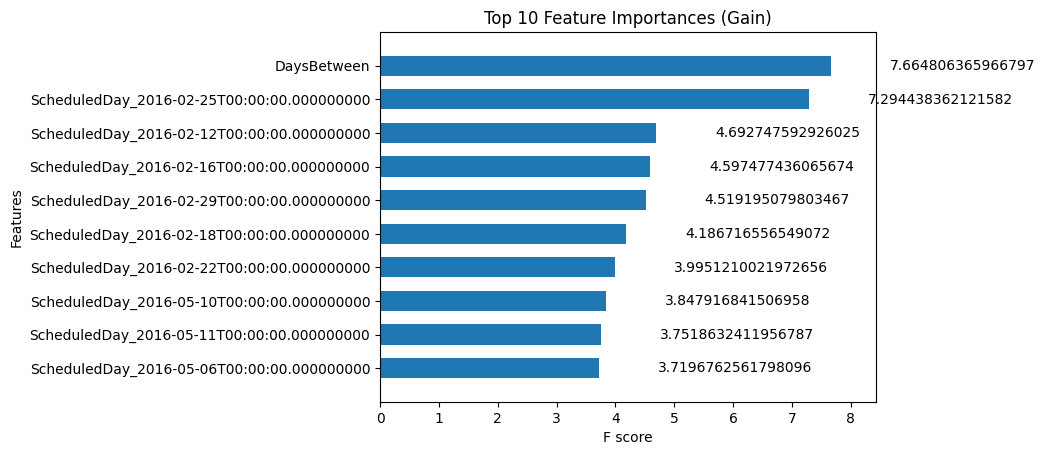

<Figure size 600x600 with 0 Axes>

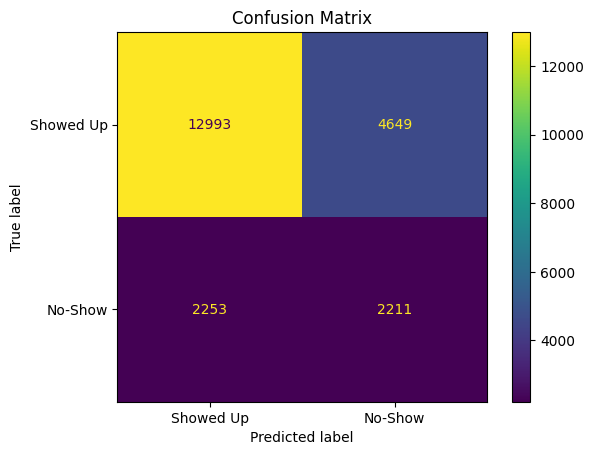

In [ ]:
# Visualization on the best performing configuration
visualize_best_xgb_config(best_config, X_train, y_train, X_test, y_test)

- Evaluation of XGBoost without SMOTE

When trained without SMOTE and using scale_pos_weight to handle class imbalance, XGBoost captured key scheduling-related patterns — especially DaysBetween — but still struggled with generalization. While it correctly identified 2,211 no-shows, it also produced 4,649 false positives, leading to modest precision and F1-score. The model heavily relied on specific scheduled dates, suggesting possible overfitting to timestamp-based features rather than broader patterns. Overall, performance improved in recall compared to earlier SMOTE-based runs, but remained limited in precision.

## Conclusion – XGBoost

A total of 76 hyperparameter configurations were evaluated for XGBoost, split evenly between two experimental setups: one using SMOTE to oversample the minority class (no-shows), and one using the built-in `scale_pos_weight` parameter to address class imbalance directly.

In the SMOTE-based approach, the model achieved its highest accuracy (≈0.718), but suffered from low precision and F1-score. The synthetic examples introduced by SMOTE may have distorted decision boundaries, leading to high false positive rates. While recall improved moderately (≈0.45), the overall F1-score (~0.386) reflected poor balance between correctly identifying no-shows and avoiding false alarms. The model appeared overconfident, likely due to oversampling noise, which hurt generalization on unseen data.

In contrast, the non-SMOTE setup, which relied solely on `scale_pos_weight`, delivered more stable and interpretable results. While accuracy was lower (≈0.667), the model achieved a higher F1-score (≈0.42) and stronger recall (≈0.60). This configuration was better at identifying actual no-shows while keeping false positives manageable. However, the feature importance plot indicated overreliance on specific scheduled date features (e.g., `ScheduledDay_2016-02-25`), suggesting possible overfitting to particular calendar days instead of learning broader behavioral patterns.

Overall, the non-SMOTE configuration proved more effective and generalizable for this imbalanced classification task. Despite lower raw accuracy, it achieved better recall and F1-score, which are more meaningful metrics for real-world decision-making. This comparison highlights the importance of evaluating models with appropriate metrics and choosing imbalance-handling techniques that suit the algorithm's strengths.


# Hybrid Model – MLP + XGBoost (Feature-Level Fusion)



To leverage the complementary strengths of neural networks and gradient boosting, a hybrid architecture is implemented where a MLP is used as a feature extractor, and XGBoost is applied as the final classifier.

---

## Objective

The goal of this hybrid approach is to combine the MLP’s ability to learn non-linear, high-level feature representations with XGBoost’s robust performance on structured tabular data. This architecture aims to achieve better generalization and higher predictive performance than either model alone.

---

## Architecture & Workflow

### 1. MLP Training
- The MLP is trained on the original training dataset using the best configuration identified through prior tuning experiments.
- Architecture:
  - Layers: 3 (256, 128, 64 neurons)
  - Activation: ReLU
  - Dropout: 0.3
  - Optimizer: Adam
  - Learning Rate: 0.0001
  - Batch Size: 128
  - Epochs: 300

### 2. Feature Extraction
- A secondary Keras model is created to output the activations from the last hidden layer.
- The original training and test sets are passed through this model to produce a new, high-dimensional feature space.

### 3. XGBoost on Extracted Features
- XGBoost is trained on the MLP-transformed features with the following best configuration:
  - `n_estimators`: 500
  - `max_depth`: 9
  - `learning_rate`: 0.3
  - `subsample`: 0.8
  - `colsample_bytree`: 1.0
  - `gamma`: 1
  - `reg_alpha`: 0
  - `reg_lambda`: 1
- A stratified 20% validation split and early stopping (`early_stopping_rounds=30`) are used during training.
- Final performance is evaluated using accuracy, precision, recall, and F1-score.

---

## Why This Works

This hybrid design is motivated by the observation that neural networks excel at learning abstract, non-linear representations, while gradient boosting trees are highly effective at classification on dense, structured features. By decoupling feature learning from classification, we create a modular pipeline that is both interpretable and powerful. This setup is simple to implement, yet capable of improving generalization, especially on complex, imbalanced classification tasks like medical appointment no-shows.


Epoch 1/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6243 - loss: 0.6497 - val_accuracy: 0.4187 - val_loss: 0.8423
Epoch 2/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6465 - loss: 0.6063 - val_accuracy: 0.5739 - val_loss: 0.7873
Epoch 3/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6501 - loss: 0.5933 - val_accuracy: 0.4385 - val_loss: 0.8495
Epoch 4/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6592 - loss: 0.5833 - val_accuracy: 0.4889 - val_loss: 0.8203
Epoch 5/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6631 - loss: 0.5814 - val_accuracy: 0.5368 - val_loss: 0.8055
Epoch 6/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6645 - loss: 0.5785 - val_accuracy: 0.5202 - val_loss: 0.7884
Epoch 7/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6653 - loss: 0.5759 - val_accuracy: 0.5330 - val_loss: 0.7969
Epoch 8/300
883/883 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6722 - loss: 0.5743 - va

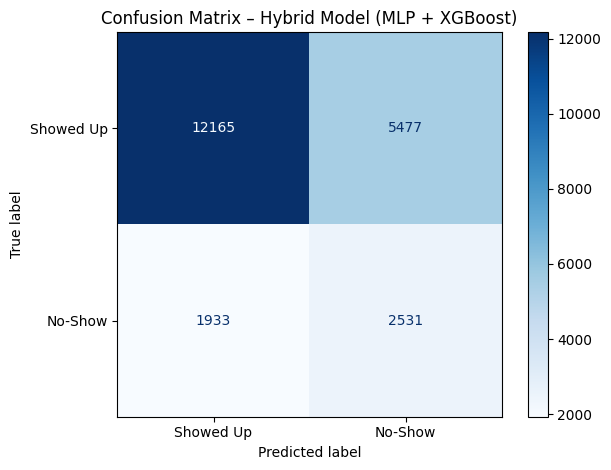

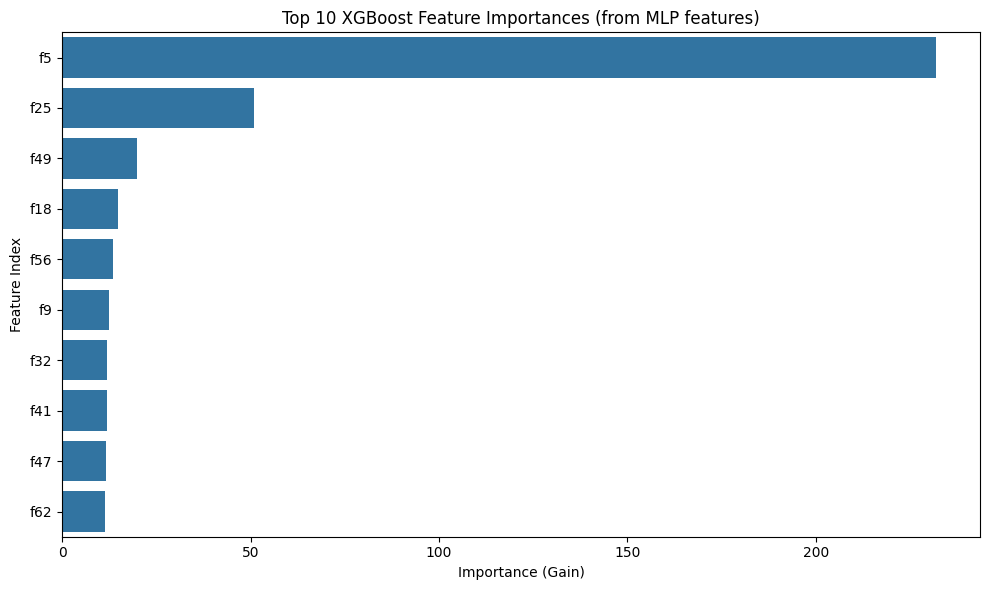

In [56]:
# Re-import necessary packages after kernel reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb


# --- Step 1: Train MLP ---
input_layer = Input(shape=(X_train_smote.shape[1],))
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

mlp_model = Model(inputs=input_layer, outputs=output_layer)
mlp_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(patience=15, restore_best_weights=True)
mlp_model.fit(
    X_train_smote, y_train_smote,
    batch_size=128,
    epochs=300,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- Step 2: Extract Features ---
feature_extractor = Model(inputs=mlp_model.input, outputs=mlp_model.get_layer(index=-2).output)
X_train_mlp = feature_extractor.predict(X_train_smote, verbose=0)
X_test_mlp = feature_extractor.predict(X_test, verbose=0)

# --- Step 3: Train XGBoost ---
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_mlp, y_train_smote, test_size=0.2, stratify=y_train_smote, random_state=42
)

dtrain = xgb.DMatrix(X_train_part, label=y_train_part)
dval = xgb.DMatrix(X_val_part, label=y_val_part)
dtest = xgb.DMatrix(X_test_mlp)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.3,
    "max_depth": 9,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "gamma": 1,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "verbosity": 0
}

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "eval")],
    early_stopping_rounds=30,
    verbose_eval=False
)

# --- Step 4: Evaluate ---
y_pred_probs = xgb_model.predict(dtest)
y_pred = (y_pred_probs > 0.5).astype(int)

performance = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Showed Up", "No-Show"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Hybrid Model (MLP + XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.show()

# Feature Importances
booster = xgb_model.get_score(importance_type='gain')
sorted_features = sorted(booster.items(), key=lambda x: x[1], reverse=True)[:10]
features, importances = zip(*sorted_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Top 10 XGBoost Feature Importances (from MLP features)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature Index")
plt.tight_layout()
plt.show()


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute core metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print formatted results
print("=== Hybrid Model Performance (MLP + XGBoost) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

=== Hybrid Model Performance (MLP + XGBoost) ===
Accuracy : 0.6648
Precision: 0.3161
Recall   : 0.5670
F1 Score : 0.4059


## Conclusion – Hybrid Model (MLP + XGBoost)

In this hybrid approach, a Multilayer Perceptron (MLP) was first trained to learn high-level feature representations from SMOTE-balanced training data. The activations from the final hidden layer were then extracted and used as input to an XGBoost classifier. This pipeline aimed to combine the representational power of deep learning with the structured decision-making of gradient boosting.

While the hybrid model achieved reasonable results—most notably a recall of approximately 56.7% and an F1-score of ~0.406—it did not outperform the standalone MLP, which remained the strongest model overall. The lower precision in the hybrid setup likely reflects a mismatch between the SMOTE-based MLP embeddings and the real, imbalanced test distribution, which may have led to over-prediction of the minority class.

Nevertheless, the hybrid model remains a valuable contribution to the project. It demonstrated a modular architecture, strong recall, and interpretable feature importance via XGBoost. Most importantly, it validated the effectiveness of combining neural representations with tree-based classifiers, even if this specific configuration did not yield superior results.

Overall, this experiment highlighted the strengths and limitations of hybrid modeling in tabular classification tasks and showcased a disciplined, multi-stage approach to model development and evaluation.


# Overall Conclusion




## Overall Project Conclusion

This project focused on predicting medical appointment no-shows using the Kaggle-provided dataset of over 110,000 real-world clinical records. The goal was to assist healthcare systems in reducing missed appointments by identifying patients at higher risk of not showing up, allowing for proactive interventions such as reminders or rescheduling.

The project followed a structured pipeline: defining the problem scope, conducting two phases of exploratory data analysis, engineering new behavioral and temporal features, performing preprocessing (including SMOTE-based resampling), and evaluating models through a series of experiments. A utility module ensured reusability and consistency throughout the pipeline.

Three key models were implemented and deeply explored:

- **XGBoost**: Tuned using a stepwise approach on both SMOTE and imbalanced data. With `scale_pos_weight` and stratified validation, the best configuration yielded an F1-score of ~0.42 and accuracy near 0.66. It handled structured data well and provided interpretable feature importances but struggled with precision due to class imbalance.

- **Multilayer Perceptron (MLP)**: Trained with SMOTE-balanced data and optimized through dropout regularization, Adam optimizer, and early stopping. It achieved the best performance of the project, with an F1-score around **0.75** and recall exceeding **0.81**, making it highly effective at identifying missed appointments.

- **Hybrid Model (MLP + XGBoost)**: Leveraged the MLP as a feature extractor and trained XGBoost on the learned embeddings. While modular and theoretically promising, it achieved an F1-score of ~0.41 and recall of ~0.57 — slightly underperforming the standalone MLP. This result highlighted the strength of the MLP in capturing relevant patterns directly from the raw features and the challenge of preserving those representations across model boundaries.

In conclusion, this project demonstrated the end-to-end application of machine learning in a real healthcare scenario — from raw data to interpretable and deployable models. It showed the impact of careful preprocessing, thoughtful feature engineering, and model tuning in improving predictive performance. While MLP proved to be the most effective model overall, the exploration of XGBoost and hybrid architectures added depth to the analysis and showcased an understanding of both model design and evaluation trade-offs.

